In [7]:
import numpy as np
import os

import librosa, librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline



In [383]:
SR = 44100
N_FFT = 1024             # 23 ms
HOP_LENGTH = int(0.01*SR)  # 10 ms
fft_frequencies = librosa.fft_frequencies(sr=SR, n_fft=N_FFT)
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmax=22050)

print(" fft:", fft_frequencies[[6,15,36]])
print(" mel:", mel_frequencies[[9,20,45]])
print("note:",librosa.note_to_hz(['C4', 'D5','G6']))

 fft: [  258.3984375    645.99609375  1550.390625  ]
 mel: [  283.42901404   629.84225341  1537.55266728]
note: [  261.6255653    587.32953583  1567.98174393]


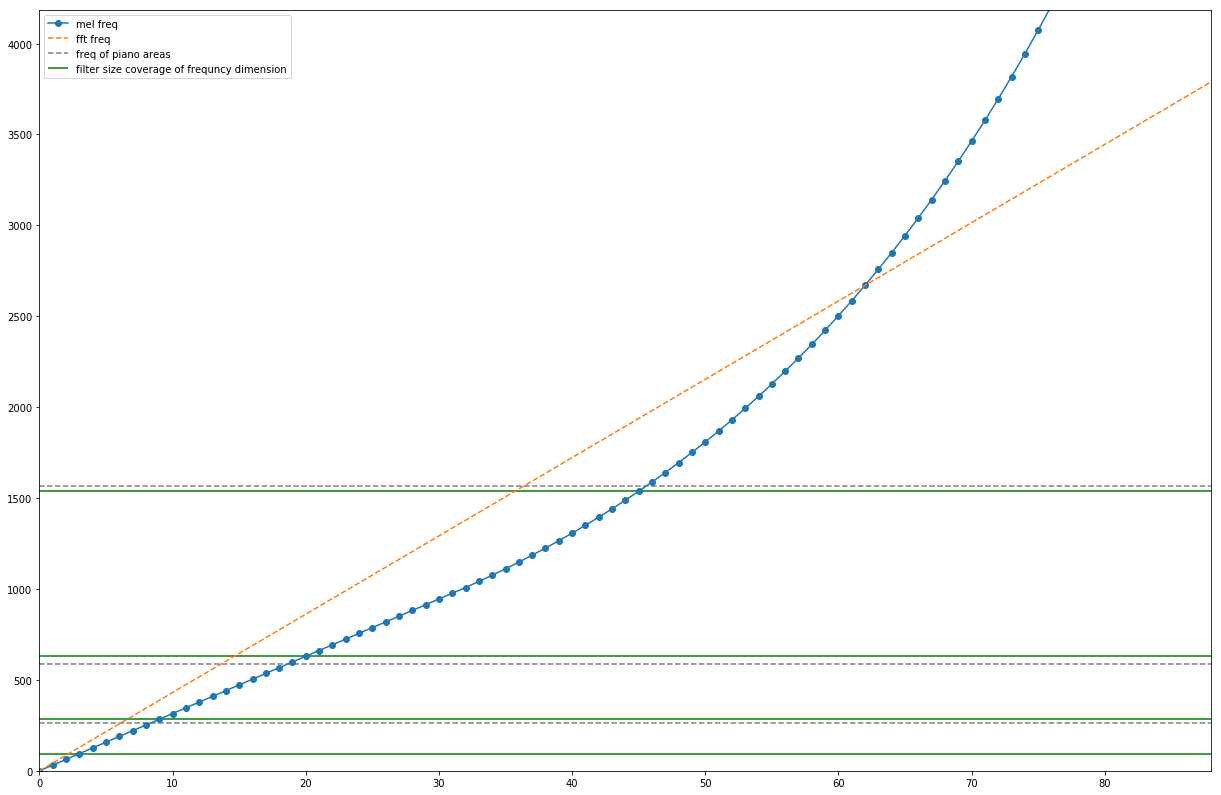

In [387]:
fig1, ax1 = plt.subplots(figsize=(21,14))
ax1.plot(range(128),mel_frequencies, 'o-', label='mel freq')
ax1.plot(range(128),fft_frequencies[:128], '--', label = 'fft freq')
ax1.hlines(librosa.note_to_hz(['C4', 'D5','G6']), 0, 128, linestyle='--', alpha=0.5, 
           label='freq of piano areas')
ax1.hlines(mel_frequencies[[3,9,20,45]], 0, 128, color='green',
           label='filter size coverage of frequncy dimension')
plt.xlim([0, 88])
plt.ylim([0, librosa.note_to_hz('C8')])
plt.legend()

In [1]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
from builtins import range
from sklearn.metrics import classification_report
import librosa, librosa.display
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Flatten, Input, Reshape, Dropout, Permute
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"]="0" # the number of the GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3 # percentage to be used
set_session(tf.Session(config=config))

from kapre.time_frequency import Melspectrogram, Spectrogram
from global_config import *

from vis.utils import utils
from keras import activations

Using TensorFlow backend.


Channel-last, i.e., (None, n_freq, n_time, n_ch)


In [92]:
def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.

    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()

Text(0.5,1,u'log-melspectrogram of pn')

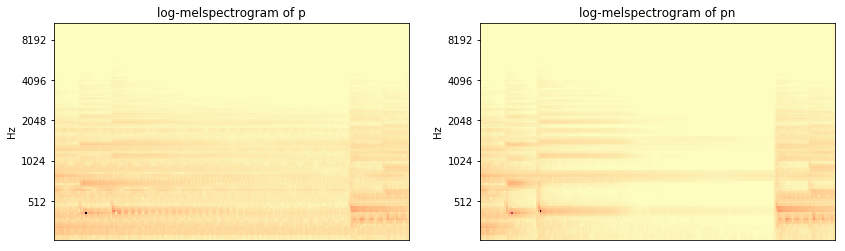

In [24]:
# display kapre Melspectrogram or Spectrogram

from librosa import display
def visualise_model(y, modelvis, logam=False):
    n_ch, nsp_src = modelvis.input_shape[1:]
    src = y
    src = src[:nsp_src]
    src_batch = src[np.newaxis, np.newaxis, :]
    pred = modelvis.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    
    if logam:
        result = librosa.logamplitude(result)
    display.specshow(result, 
                     y_axis='mel', sr=SR)
    return result
    
    
dir_pedal_npy = DIR_PEDAL_SEGMENT_NPY
yp = np.load(os.path.join(dir_pedal_npy, validation.iloc[100].filepath.split('.')[0]+'.npy'))
ynp = np.load(os.path.join(dir_pedal_npy, validation.iloc[101].filepath.split('.')[0]+'.npy'))

modelvis = Sequential()
modelvis.add(Melspectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, sr=SR, n_mels=128, power_melgram=2.0, 
                         return_decibel_melgram=True,
                         input_shape=typeshape))

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('log-melspectrogram of p')
pimg = visualise_model(yp, modelvis, logam=True)
plt.subplot(1, 2, 2)
npimg = visualise_model(ynp, modelvis, logam=True)
plt.title('log-melspectrogram of pn')

## Display deconved layers

In [371]:
from scipy import signal
import scipy.ndimage

def get_deconve_mask(W, layer_names, SRC, depth):
    ''' 
    This function returns the deconvolved mask.
    W: weights. shape: (#conv_layers -by- #channels_out - #channels_in - #rows - #cols)
    layer_names: array of layer names from keras
    SRC: STFT representation 
    depth : integer, 0,1,2,3,.. if it's 5, and if there were 5 conv-MP layers, it will deconve from the deepest (i.e. the highest-level feature)
    '''
    def relu(x):
        return np.maximum(0., x)

    def get_deconvolve(images, weights):
        ''' input image is expected to be unpooled image, i.e. 'upsampled' with switch matrix. 
        weights: 4-d array. (#channels_out - #channels_in - #rows - #cols) e.g. 64-64-3-3. 
                 When deconvolve, 'out' is input of deconvolution and vice versa. 
                 Check the names below: 'num_before_deconv' and 'num_after_deconv', which are self-explanatory 
        '''
        num_before_deconv, num_after_deconv, num_row, num_col = weights.shape
        flipped_weights = weights[:, :, ::-1, ::-1] # fliplr and flipud to use in deconvolution.
        reversed_flipped_weights = np.zeros((num_after_deconv, num_before_deconv, num_row, num_col))
        for dim0 in xrange(num_after_deconv): # reverse the dimension to reuse get_convolve function.
            for dim1 in xrange(num_before_deconv):
                reversed_flipped_weights[dim0, dim1, :, :] = flipped_weights[dim1, dim0, :, :]

        return get_convolve(images, reversed_flipped_weights)

    def get_unpooling2d(images, switches, ds=2):
        '''input imge size is (almost) half of switch'''
        num_image, num_img_row, num_img_col = images.shape
        num_switch, num_swt_row, num_swt_col = switches.shape
        # out_images = np.zeros((num_image, num_row*ds, num_col*ds))
        out_images = np.zeros((num_image, num_swt_row, num_swt_col))
        for ind_image, image in enumerate(images):
            out_images[ind_image, :num_img_row*ds, :num_img_col*ds] = np.multiply(scipy.ndimage.zoom(image, ds, order=0), switches[ind_image, :num_img_row*ds, :num_img_col*ds]) # [1 ] becomes [1 1; 1 1], then multiplied.
        return out_images

    def get_convolve(images, weights):
        ''' images: 3-d array, #channel-#rows-#cols e.g. (1,257,173)
            weights: 4-d array, (#channels_out - #channels_in - #rows - #cols) e.g. (64,1,3,3) for the first convolution
        '''
        num_out, num_in, num_row_w, num_col_w = weights.shape
        num_row_img, num_col_img = images.shape[1], images.shape[2]
        out_images = np.zeros((num_out, num_row_img, num_col_img))

        for ind_input_layer in xrange( weights.shape[1] ):
            for ind_output_layer in xrange( weights.shape[0] ):

                out_images[ind_output_layer, :, :] += signal.convolve2d(images[ind_input_layer, :, :], weights[ind_output_layer, ind_input_layer, :, :], mode='same')

        return out_images

    def get_MP2d(images, ds=2):
        ''' 
        images: 3-d array, #channel-#rows-#cols e.g. (1,257,173)
        ds = integer, which downsample by. e.g. 2
        return: result and switch
            result: downsampled images (with 2d MAX)
            switch: list of switch matrix; that showing from which position each 'max' values come.
        * ignore_border = True is assumed.
        '''

        num_image, num_row, num_col = images.shape
        out_images = np.zeros((num_image, int(num_row/ds), int(num_col/ds)))
        switch = np.zeros((num_image, num_row, num_col))

        for ind_image, image in enumerate(images):
            for row_ind in xrange(int(num_row/ds)):
                for col_ind in xrange(int(num_col/ds)):
                    out_images[ind_image, row_ind, col_ind] = np.max( image[ds*row_ind:ds*row_ind+ds, ds*col_ind:ds*col_ind+ds] )
                    argmax_here =np.argmax( image[ds*row_ind:ds*row_ind+ds, ds*col_ind:ds*col_ind+ds] )
                    switch[ind_image, int(ds*row_ind+int(argmax_here/ds)), int(ds*col_ind+int(argmax_here%ds))] = 1

        return out_images, switch

    '''function body of get_deconve_mask begins here.'''
    MAG = []
    MAG.append( np.zeros((1, SRC.shape[0], SRC.shape[1])) )

    MAG[0][0,:,:] = np.abs((SRC))

    switch_matrices = []
    procedures = []
    conv_ind = 0
    mp_ind = 0

    # [1] feed-forward path.
    # print('feed-forward...')
    for layer_ind, layer_name in enumerate(layer_names):
        if layer_name == "Convolution2D":
            MAG.append(relu(get_convolve(images=MAG[-1], weights=W[conv_ind])))
            procedures.append('conv')
            conv_ind += 1

        elif layer_name == "MaxPooling2D":
            if depth==4 and mp_ind == depth-1:
                result, switch = get_MP2d(images=MAG[-1], ds=4)
            else:
                result, switch = get_MP2d(images=MAG[-1], ds=2)
            MAG.append(result)
            procedures.append('MP')
            switch_matrices.append(switch)
            mp_ind += 1

        if mp_ind == depth:
            break;

        elif layer_name == "Flatten":
            break

    # [2] 'deconve' # numbers below come from vggnet5 model (when depth == 4).
    revMAG = list(reversed(MAG)) # len(revMAG)==9, revMAG[i].shape = (64,16,10), (64,32,21), (64,32,21), (64,64,43), (64,128,86),(64,128,86),(64,257,173),(1,257,173)
    revProc = list(reversed(procedures)) # len(revProc)==8, ['MP', 'conv', 'MP', 'conv', 'MP', 'conv', 'MP', 'conv']
    revSwitch = list(reversed(switch_matrices)) # len(revSwitch)==4, revSwitch[0].shape = (64, 32, 21), (64, 64, 43), (64, 128, 86), (64, 257, 173)
    revW = list(reversed(W)) #len(revW)==4, (64,64,3,3), (64,64,3,3), (64,64,3,3), (64,1,3,3)

    num_outputs = revMAG[0].shape[0] # number of channels in the layer we consider (layer at 'depth')

    deconved_final_results = np.zeros((num_outputs, SRC.shape[0], SRC.shape[1]))

    # print('feed-back...')
    for ind_out in xrange(num_outputs): 
        # Init with values that only (ind_out)-th feature map be considered
        deconvMAG 				= [None]
        deconvMAG[0] 			= np.zeros((1, revMAG[0].shape[1], revMAG[0].shape[2]))
        deconvMAG[0][0, :, :] 	= revMAG[0][ind_out, :, :] # assign with the spectrogram at the Last stage (at 'depth'). 

        revSwitch_to_use 				= [None]*len(revSwitch)
        revSwitch_to_use[0] 			= np.zeros((1, revSwitch[0].shape[1], revSwitch[0].shape[2]))
        revSwitch_to_use[0][0, :, :] 	= revSwitch[0][ind_out, :, :]
        revSwitch_to_use[1:]			= revSwitch[1:]

        revW_to_use    		= [None] * len(revW)
        revW_to_use[0]		= np.zeros((1, revW[0].shape[1], revW[0].shape[2], revW[0].shape[3]))
        revW_to_use[0][0,:,:,:] = revW[0][ind_out, :, :, :] #only weights to yield (ind_out)-th feature map.
        revW_to_use[1:]			= revW[1:]

        # Go!
        # print('-------feed-back- %d --' % ind_out)
        unpool_ind = 0
        deconv_ind = 0
        for proc_ind, proc_name in enumerate(revProc):
            if proc_name == 'MP':
                # print 'unpool: %d, %d' % (unpool_ind, proc_ind)
                deconvMAG.append(relu(get_unpooling2d(images=deconvMAG[proc_ind], switches=revSwitch_to_use[unpool_ind])))
                unpool_ind += 1

            elif proc_name == "conv":
                # print 'deconv: %d, %d' % (deconv_ind, proc_ind)
                deconvMAG.append(get_deconvolve(images=deconvMAG[proc_ind], weights=revW_to_use[deconv_ind]))
                deconv_ind += 1

        deconved_final_results[ind_out, :, :] = deconvMAG[-1][:,:,:]

    return deconved_final_results

def load_weights(input_type, dataset_type, n_freq, n_time):
    ''' Load keras config file and return W
    '''
    import h5py
    model_name = 'cnnkernel-{}'.format(input_type)
    exp_name = 'sub-{}_{}_f{}t{}'.format(dataset_type, model_name, n_freq, n_time)
    model = keras.models.load_model(os.path.join(DIR_SAVE_MODEL,"{}_best_model.h5".format(exp_name)),
                                    custom_objects={'Spectrogram':Spectrogram})
    model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(exp_name)))
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    
    W = []
    convlayer_nums = []
    for name in layer_dict.keys():
        if 'conv' in str(name):
            convlayer_nums.append(int(str(name).split('_')[-1]))
    convlayer_nums.sort()
    convlayer_names=[]
    for num in convlayer_nums:
        convlayer_names.append('conv2d_{}'.format(num))
    
    for layer_name in convlayer_names:        
        weights = layer_dict[layer_name].get_weights()[0]
        weights = np.moveaxis(weights, -1, 0)
        weights = np.moveaxis(weights, -1, 1)
        
        W.append(weights[:,:,:,:])
        
    layer_names = []
    for idx in xrange(len(convlayer_names)):
        layer_names.append('Convolution2D')
        layer_names.append('MaxPooling2D')
    layer_names.append('Flatten')    

    return W, layer_names


def get_layer_maskes(dir_pedal_npy, validation, p_ind, depth, W, layer_names):
    yp = np.load(os.path.join(dir_pedal_npy, validation.iloc[p_ind].filepath.split('.')[0]+'.npy'))
    SRCp = librosa.stft(yp, n_fft=N_FFT, hop_length=HOP_LENGTH)
    deconvedMASKSp = get_deconve_mask(W[:depth], layer_names, SRCp, depth) # size can be smaller than SRC due to downsampling
    
    ynp = np.load(os.path.join(dir_pedal_npy, validation.iloc[p_ind+1].filepath.split('.')[0]+'.npy'))
    SRCnp = librosa.stft(ynp, n_fft=N_FFT, hop_length=HOP_LENGTH)
    deconvedMASKSnp = get_deconve_mask(W[:depth], layer_names, SRCnp, depth) # size can be smaller than SRC due to downsampling
    
    return SRCp, deconvedMASKSp, SRCnp, deconvedMASKSnp

In [280]:
batch_size = 1
dataset_type = 'segment'
input_type = 'spectrogram'
split_kv = {'onset-spectrogram':4, 'onset-melspectrogram':3, 
            'segment-spectrogram':7, 'segment-melspectrogram':5}
split_indx = split_kv['{}-{}'.format(dataset_type,input_type)]
typeshape = SEGMENT_INPUT_SHAPE
dir_pedal_npy = DIR_PEDAL_SEGMENT_NPY

if input_type == 'melspectrogram':
    n_freqs = [9,20,45,3, 3, 3]
elif input_type == 'spectrogram':
    n_freqs = [6,15,36,3, 3, 3]
n_times = [3,3, 3, 10,20,30]

csv_path = os.path.join(DIR_PEDAL_METADATA, "pedal-{}_subdf.csv".format(dataset_type))
tracks = pd.read_csv(csv_path)
validation = tracks.loc[(tracks['category'] == 'valid') & (tracks['interval_time'] == split_indx)]

In [388]:
def plotlayer_segment_spectrogram_ft(ftind, n_freqs, n_times, input_type, dataset_type, dir_pedal_npy, validation, instance):
    print("Using cnn model with n_freq={} and n_time={}.".format(n_freqs[ftind], n_times[ftind]))
    W, layer_names = load_weights(input_type, dataset_type, n_freqs[ftind], n_times[ftind])
    num_conv_layer = len(W)

    depthmask_dicp  = {"deconvedMASKSp_1":list(), "deconvedMASKSp_2":list(), "deconvedMASKSp_3":list(), "deconvedMASKSp_4":list()}
    depthmask_dicnp = {"deconvedMASKSnp_1":list(), "deconvedMASKSnp_2":list(), "deconvedMASKSnp_3":list(), "deconvedMASKSnp_4":list()}

    for depth in [1,2,3,4]:
        print("Calculating the decoved mask for layer {}...".format(depth))
        SRCp, deconvedMASKSp, SRCnp, deconvedMASKSnp = get_layer_maskes(dir_pedal_npy, validation, instance, depth, W, layer_names)
        depthmask_dicp["deconvedMASKSp_{}".format(depth)] = deconvedMASKSp
        depthmask_dicnp["deconvedMASKSnp_{}".format(depth)] = deconvedMASKSnp

    print("Done!") 

    def displayconvspec(deconvedMASK_here, SRC):
        MASK = np.zeros(SRC.shape)
        MASK[0:deconvedMASK_here.shape[0], 0:deconvedMASK_here.shape[1]] = deconvedMASK_here
        deconvedSRC = np.multiply(SRC, MASK)
        SRC_masked = np.flipud(np.multiply(np.abs(SRC), MASK))
        display.specshow(librosa.logamplitude(SRC_masked ** 2, ref_power=1.0), y_axis='linear', sr=SR)    

    def displaylayerspec(depth, fmapinds, depthmask_dicp, depthmask_dicnp, SRCp, SRCnp):

        deconvedMASKSp = depthmask_dicp["deconvedMASKSp_{}".format(depth)]
        deconvedMASKSnp = depthmask_dicnp["deconvedMASKSnp_{}".format(depth)]
        bottomv = 18000

        plt.figure(figsize=(25, 15))

        plt.subplot(2, 4, 1)
        display.specshow(librosa.logamplitude(np.abs(SRC) ** 2, ref_power=1.0), y_axis='linear', sr=SR)
        plt.title('P logsepc')

        for ind, fmapind in enumerate(fmapinds):
            plt.subplot(2, 4, 2+ind)
            deconvedMASK_here=deconvedMASKSp[fmapind]
            displayconvspec(deconvedMASK_here, SRCp)   
            plt.ylim(bottom=bottomv)
            plt.title('P layer{}-{}'.format(depth,fmapind))


        plt.subplot(2, 4, 5)
        display.specshow(librosa.logamplitude(np.abs(SRC) ** 2, ref_power=1.0), y_axis='linear', sr=SR)
        plt.title('NP logsepc')

        for ind, fmapind in enumerate(fmapinds):
            plt.subplot(2, 4, 6+ind)
            deconvedMASK_here=deconvedMASKSnp[fmapind]
            displayconvspec(deconvedMASK_here, SRCnp)   
            plt.ylim(bottom=bottomv)
            plt.title('NP layer{}-{}'.format(depth,fmapind))


    fmapinds = [0,10,20]
    for depth in [1,2,3,4]:
        displaylayerspec(depth, fmapinds, depthmask_dicp, depthmask_dicnp, SRCp, SRCnp)
        
    return depthmask_dicp, depthmask_dicnp

In [389]:
instance = 100
segspecftmask_dicp  = {"f6t3":list(), "f15t3":list(), "f36t3":list(), "f3t10":list(), "f3t20":list(), "f3t30":list()}
segspecftmask_dicnp = {"f6t3":list(), "f15t3":list(), "f36t3":list(), "f3t10":list(), "f3t20":list(), "f3t30":list()}

Using cnn model with n_freq=6 and n_time=3.
Calculating the decoved mask for layer 1...
Calculating the decoved mask for layer 2...
Calculating the decoved mask for layer 3...
Calculating the decoved mask for layer 4...
Done!


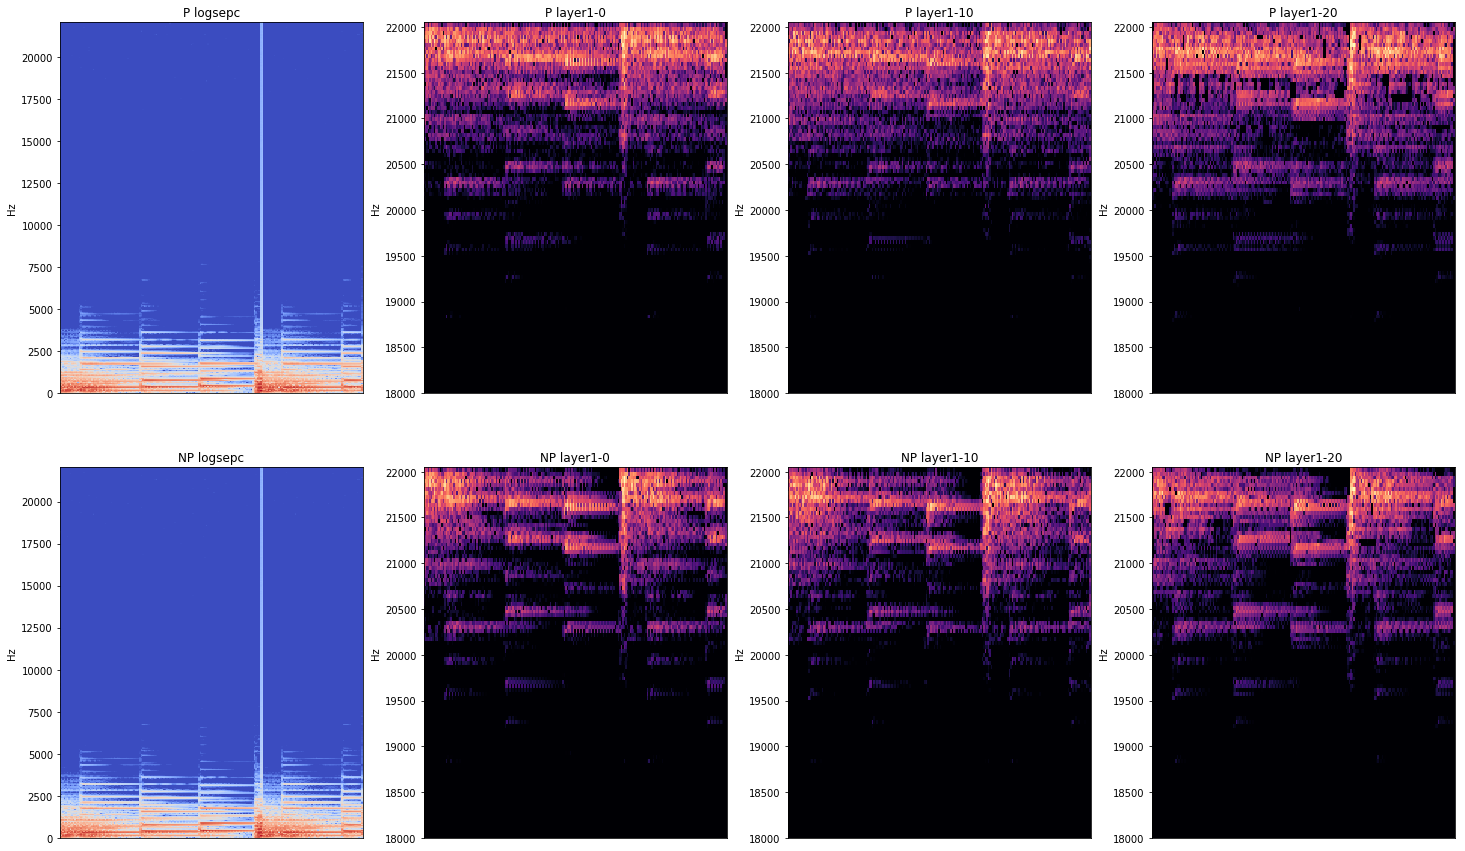

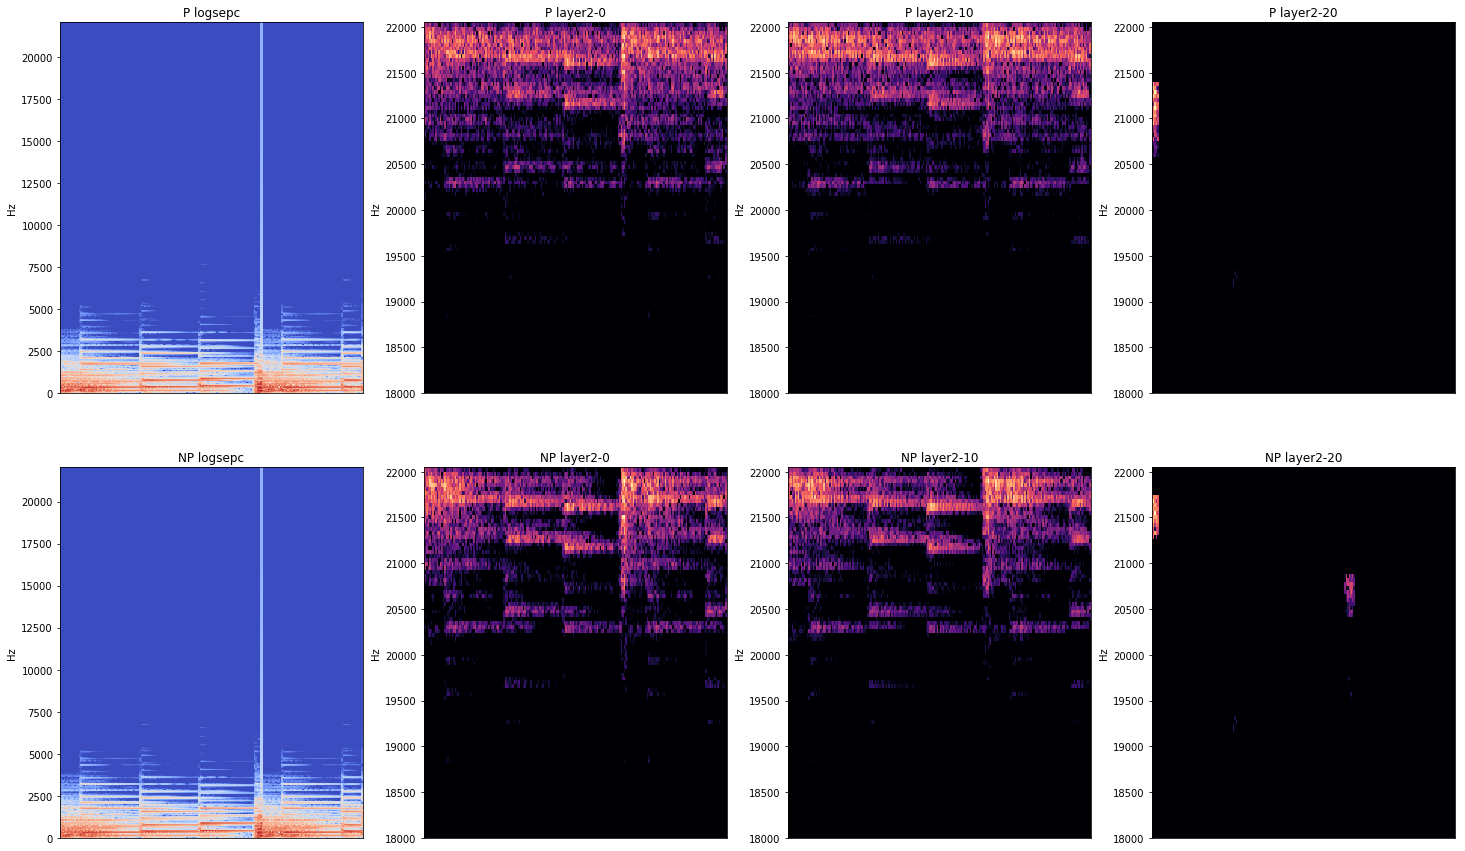

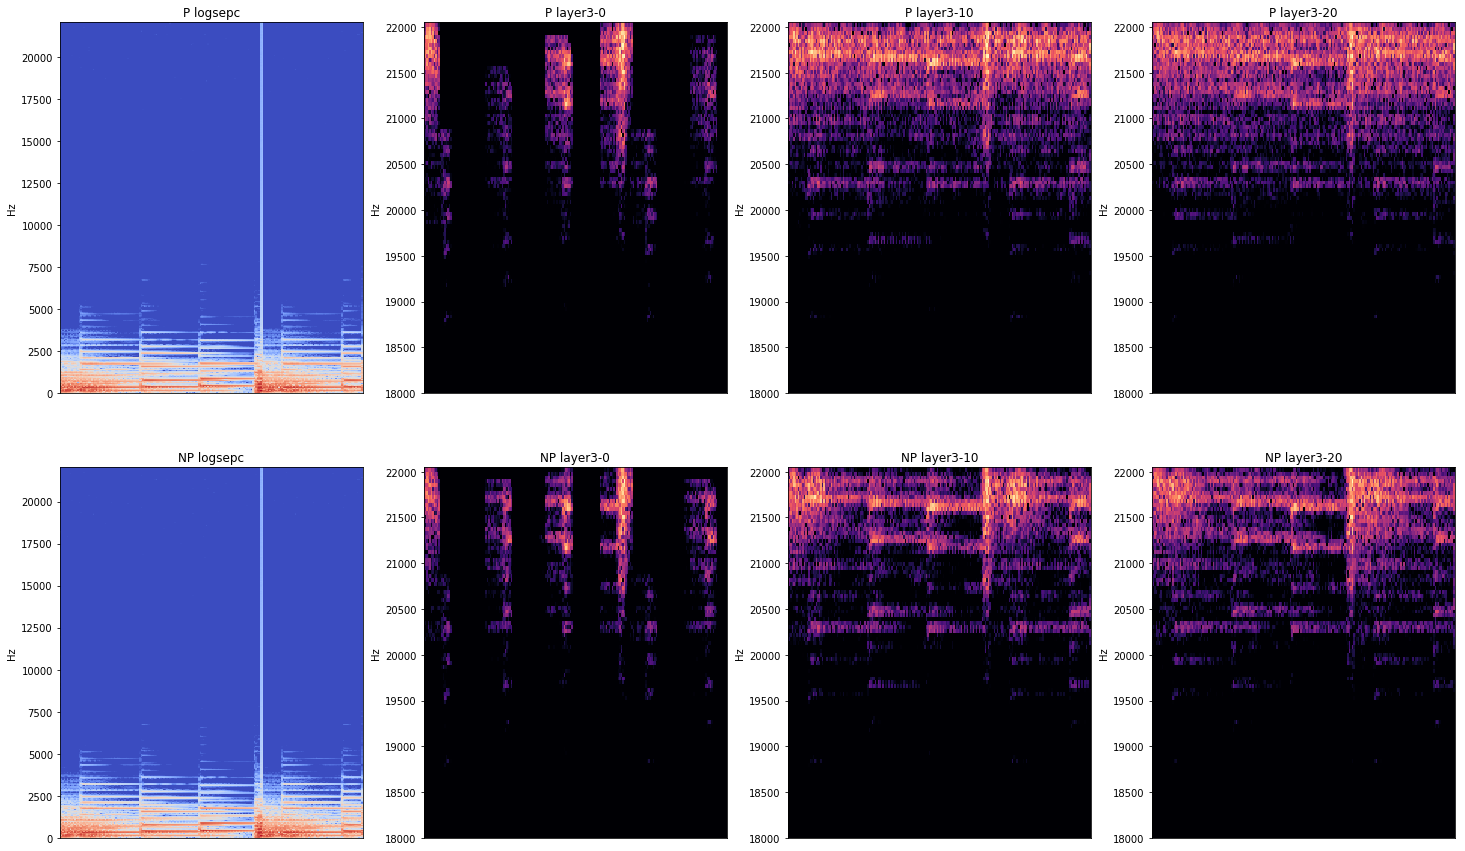

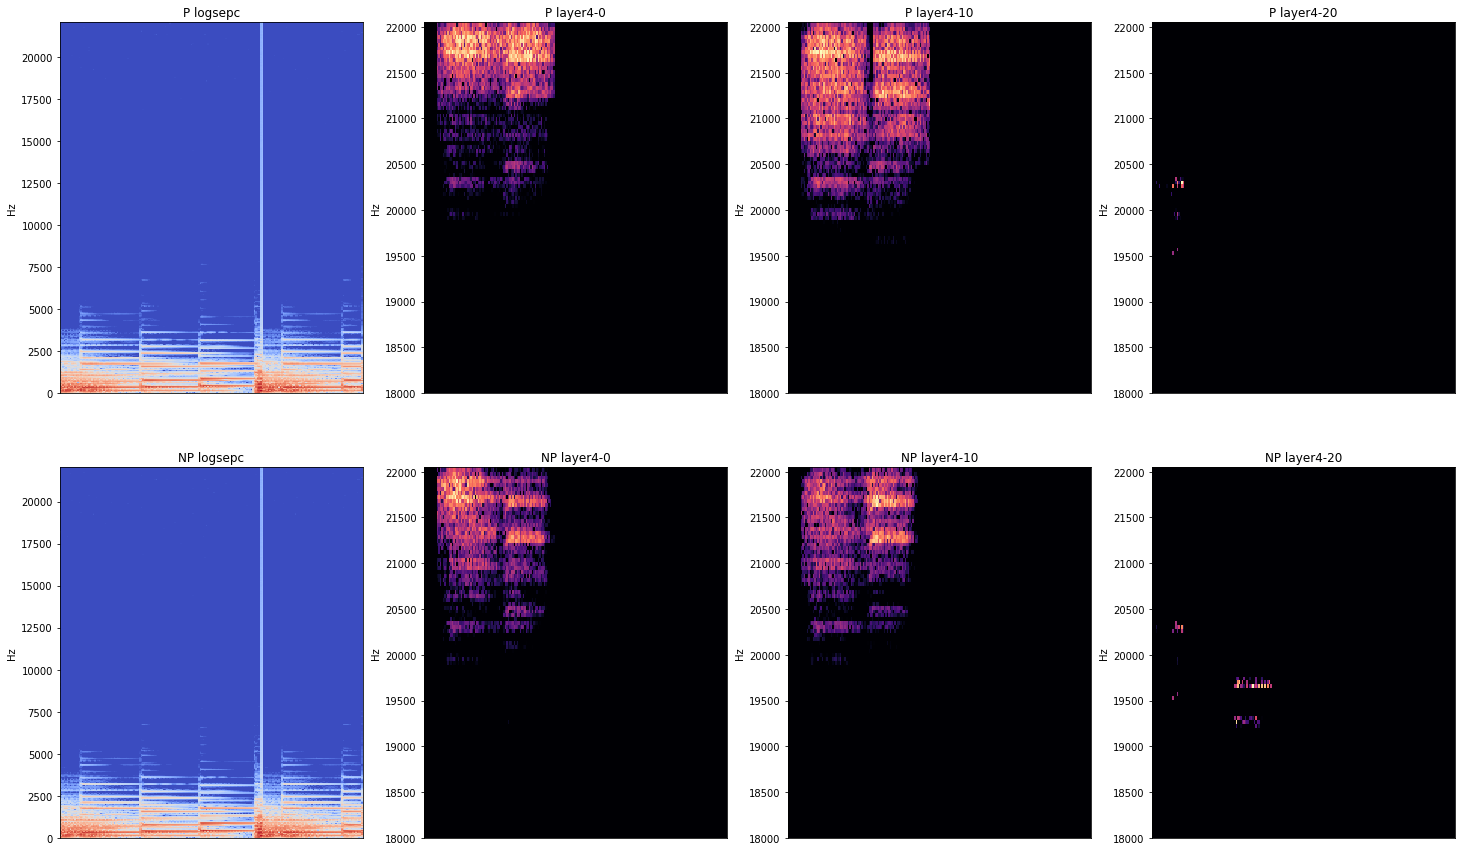

In [390]:
ftind = 0
keytext = "f{}t{}".format(n_freqs[ftind], n_times[ftind])
segspecftmask_dicp[keytext], segspecftmask_dicnp[keytext] = plotlayer_segment_spectrogram_ft(ftind, n_freqs, n_times, 
                                                                                             input_type, dataset_type, 
                                                                                             dir_pedal_npy, validation, 
                                                                                             instance)

Using cnn model with n_freq=15 and n_time=3.
Calculating the decoved mask for layer 1...
Calculating the decoved mask for layer 2...
Calculating the decoved mask for layer 3...
Calculating the decoved mask for layer 4...
Done!


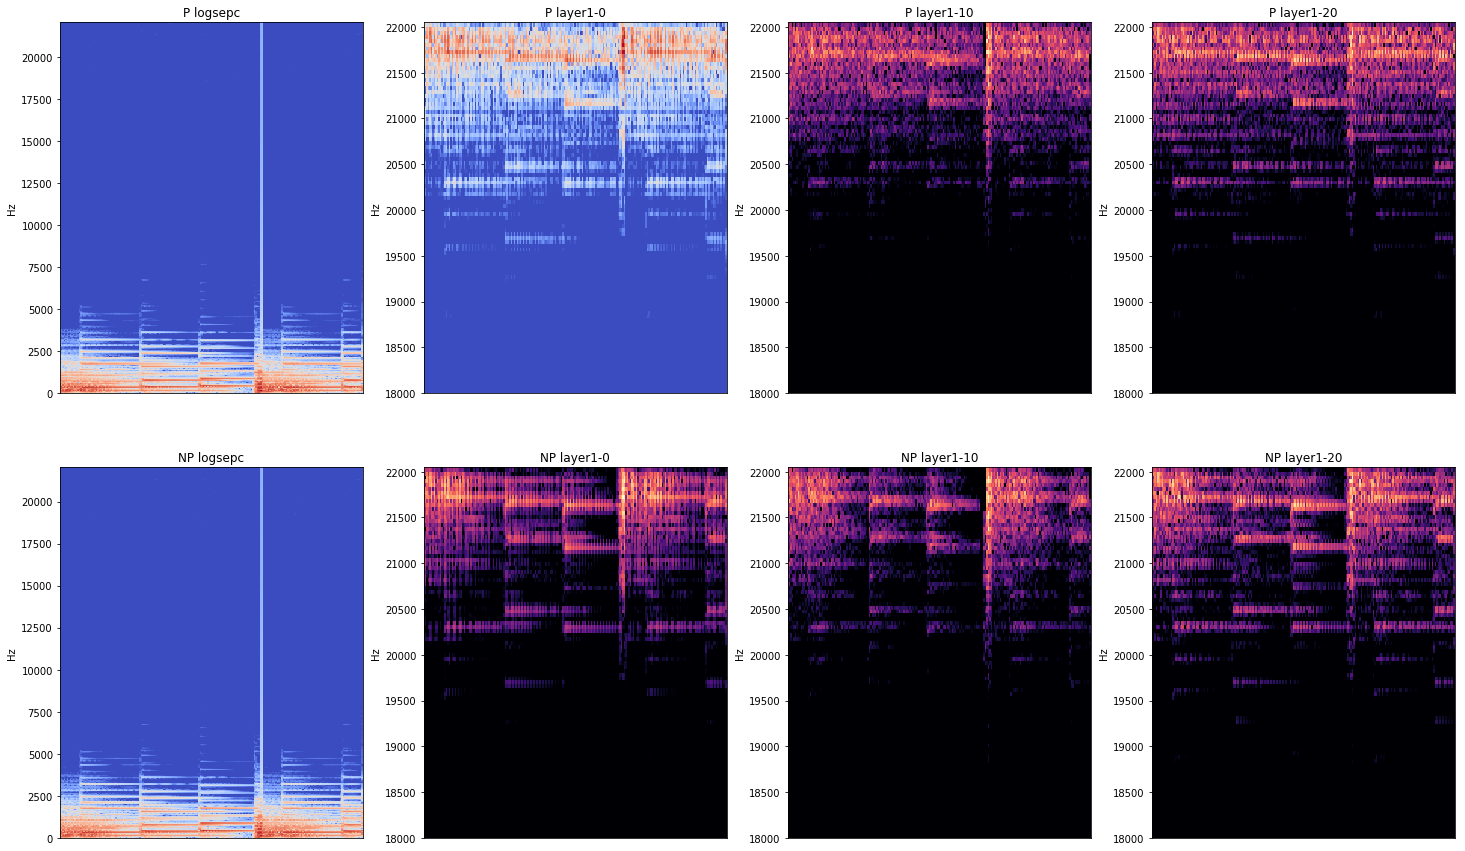

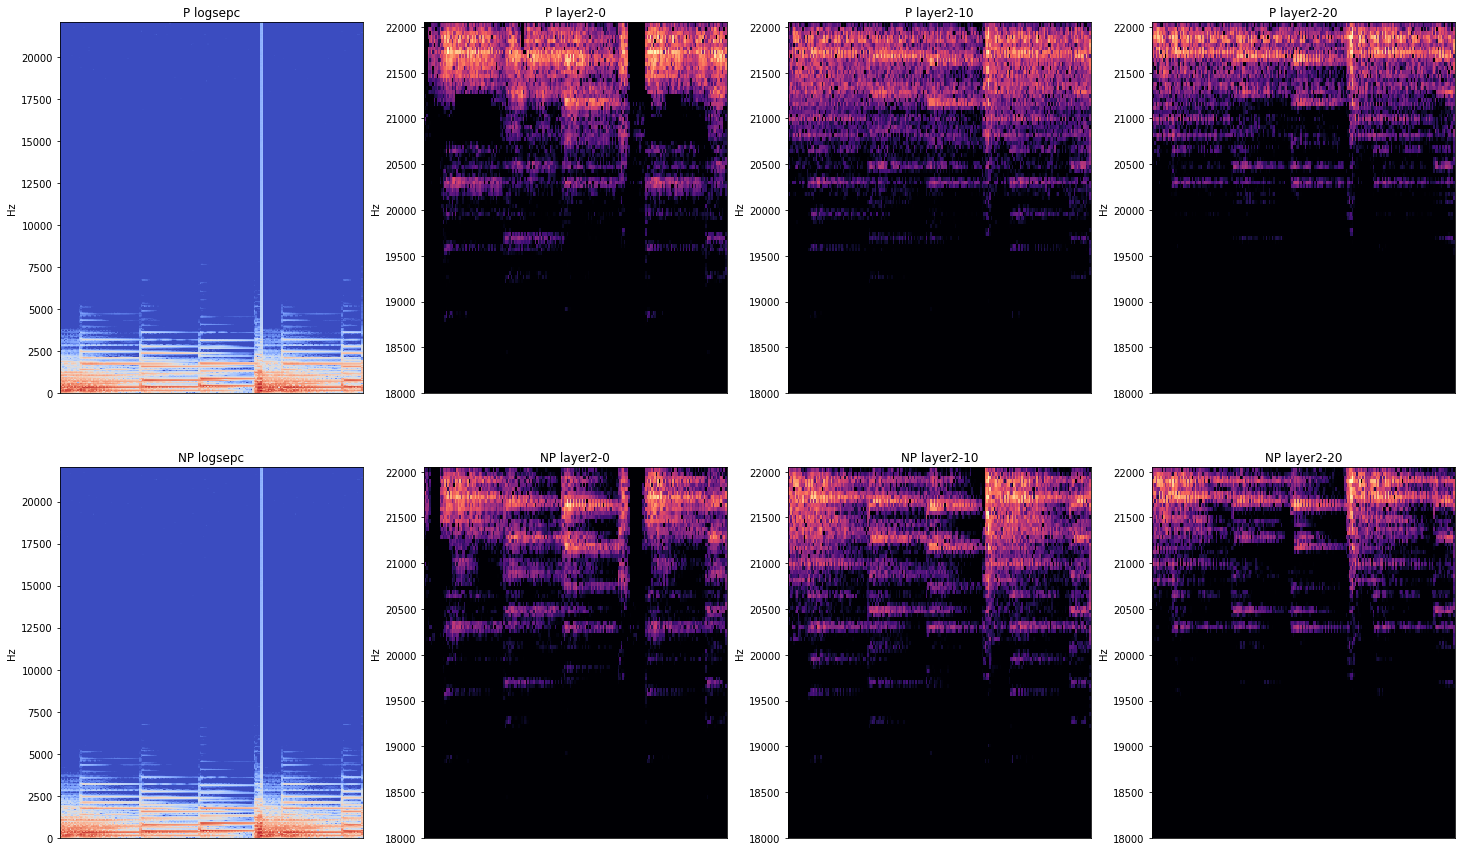

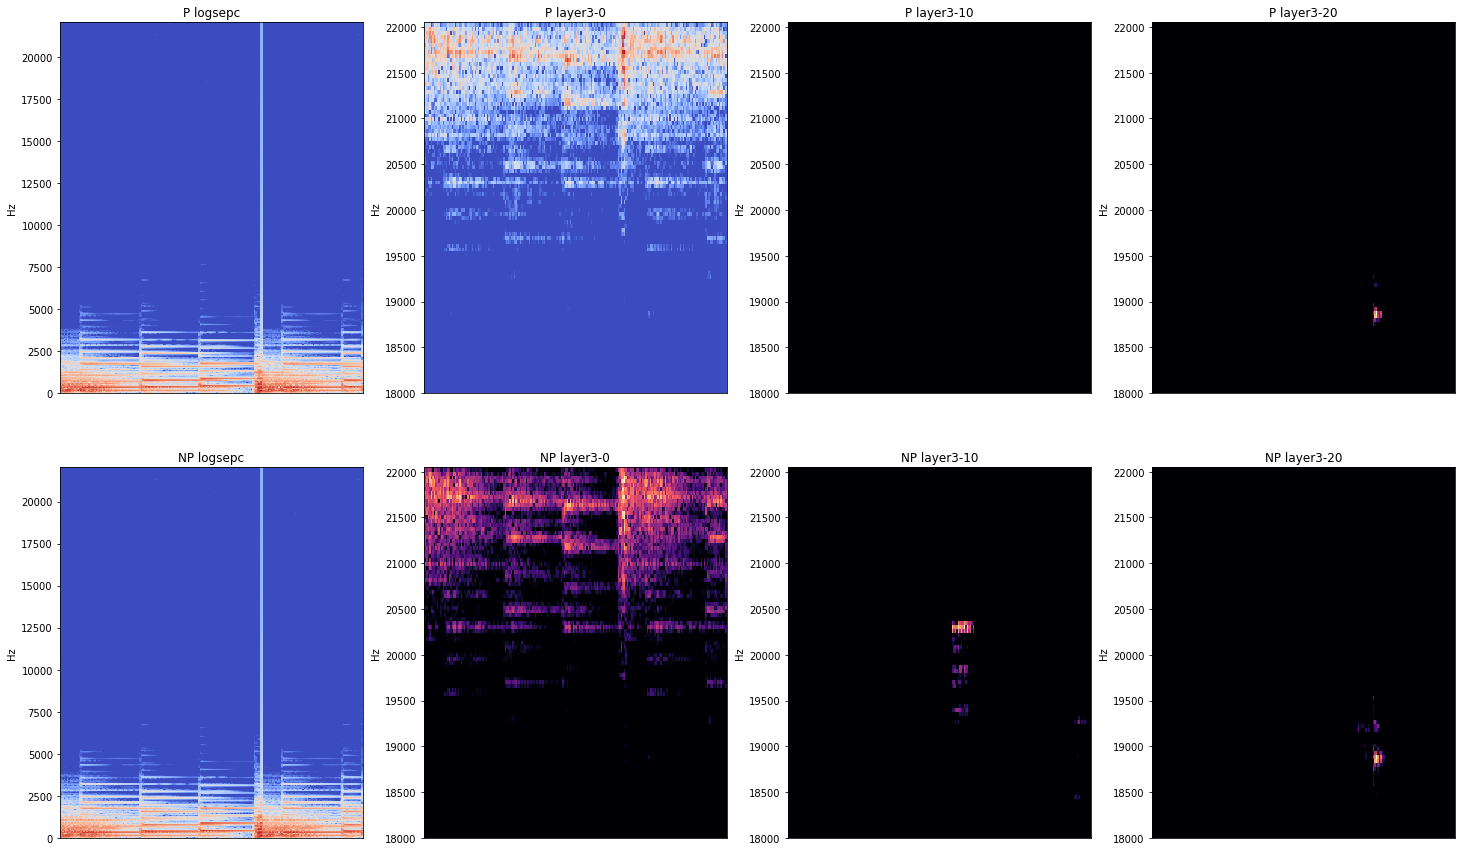

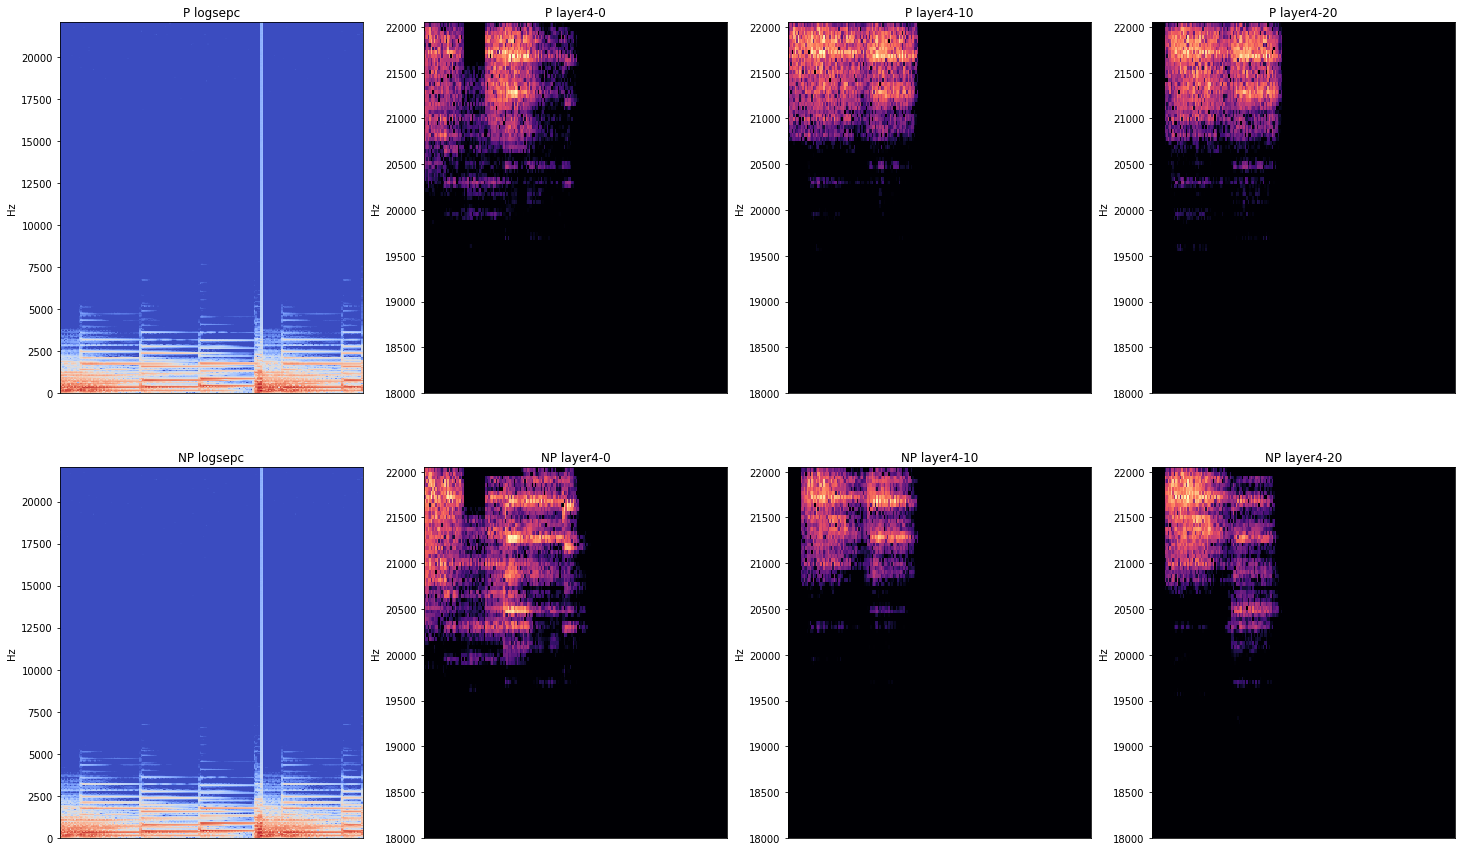

In [391]:
ftind = 1
keytext = "f{}t{}".format(n_freqs[ftind], n_times[ftind])
segspecftmask_dicp[keytext], segspecftmask_dicnp[keytext] = plotlayer_segment_spectrogram_ft(ftind, n_freqs, n_times, 
                                                                                             input_type, dataset_type, 
                                                                                             dir_pedal_npy, validation, 
                                                                                             instance)

Using cnn model with n_freq=36 and n_time=3.
Calculating the decoved mask for layer 1...
Calculating the decoved mask for layer 2...
Calculating the decoved mask for layer 3...
Calculating the decoved mask for layer 4...
Done!


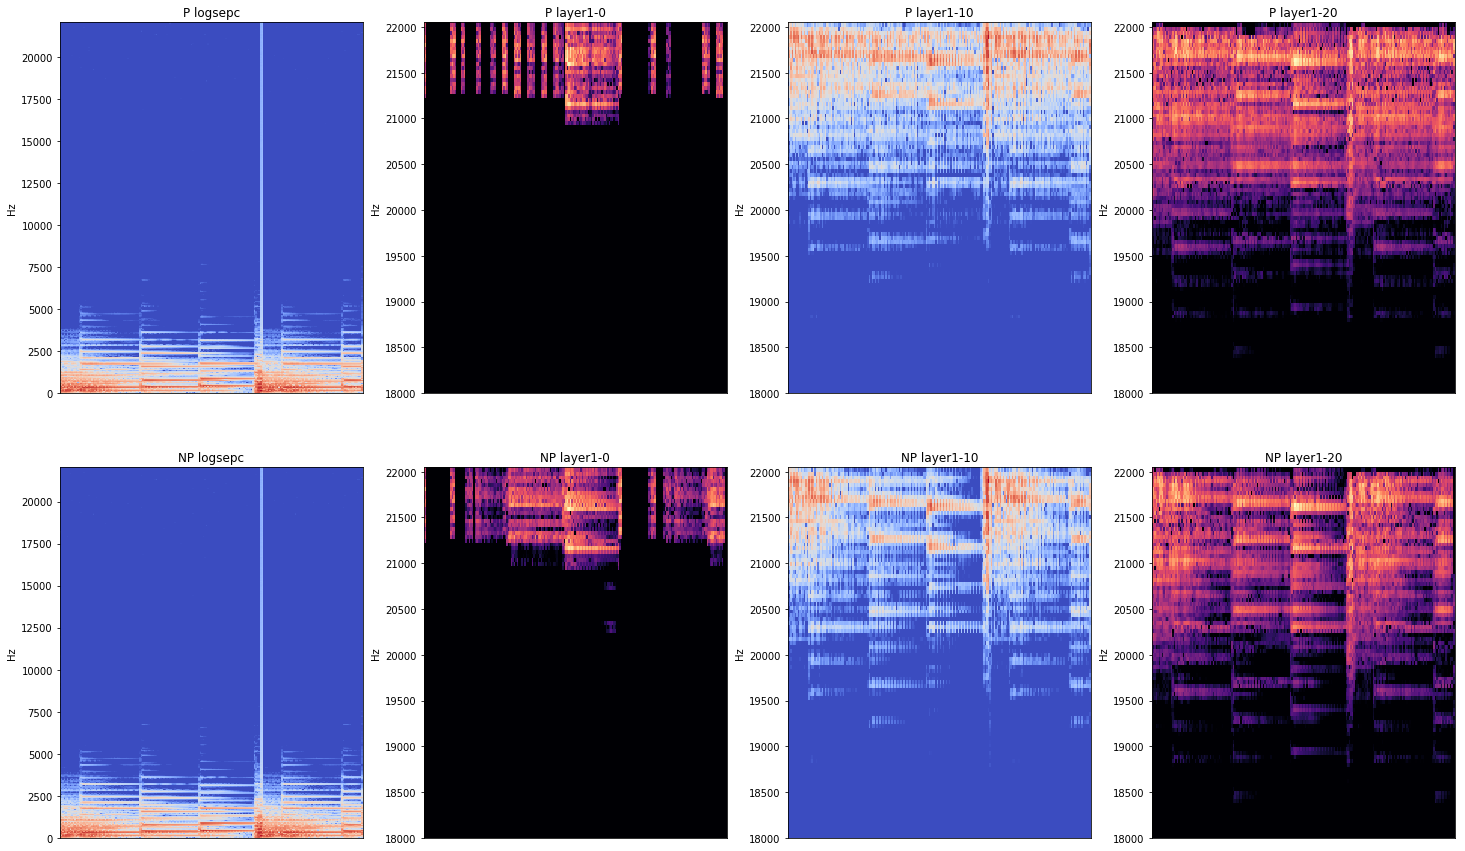

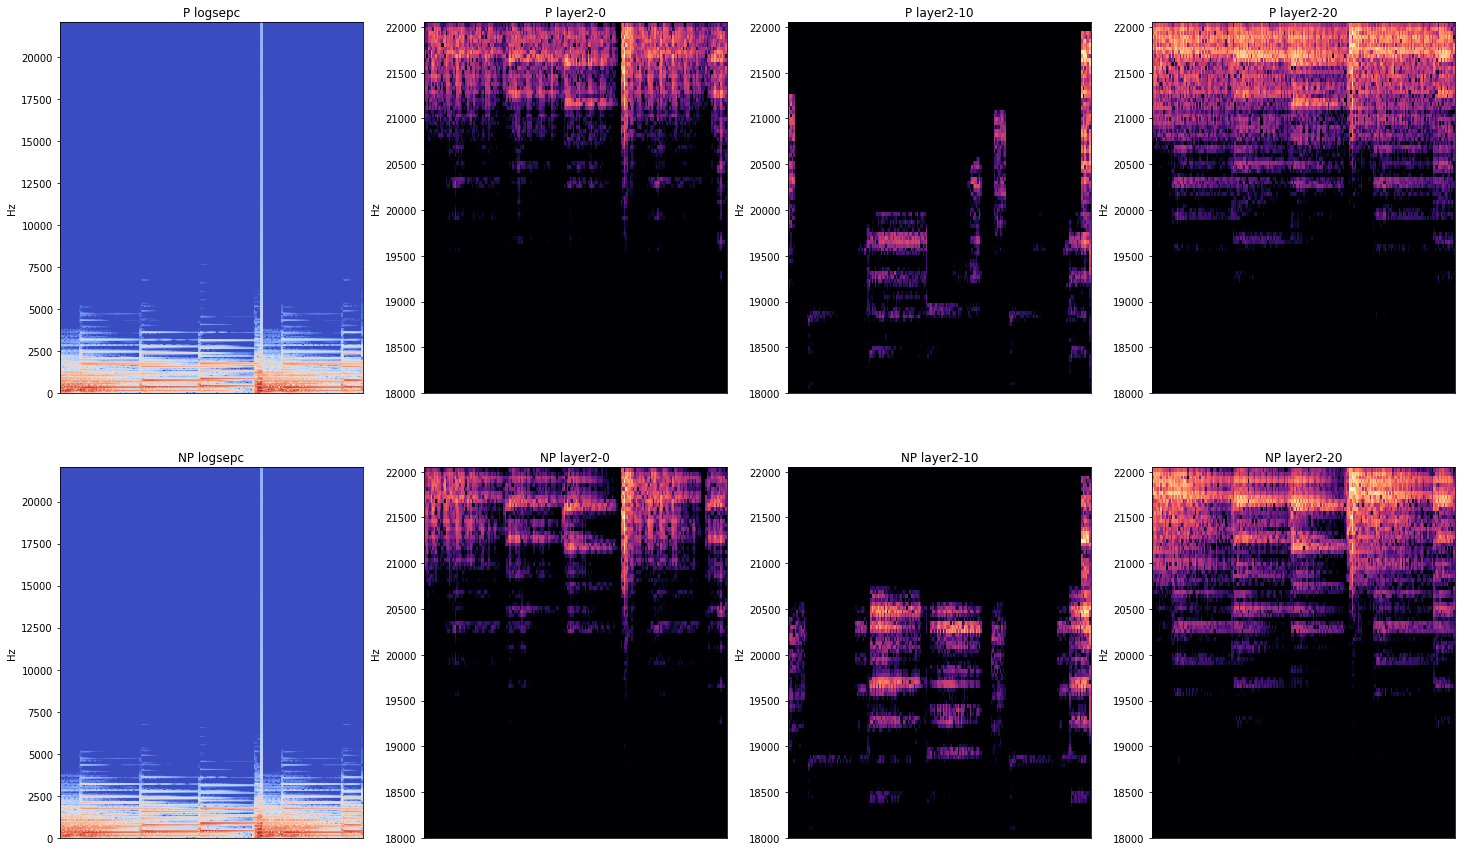

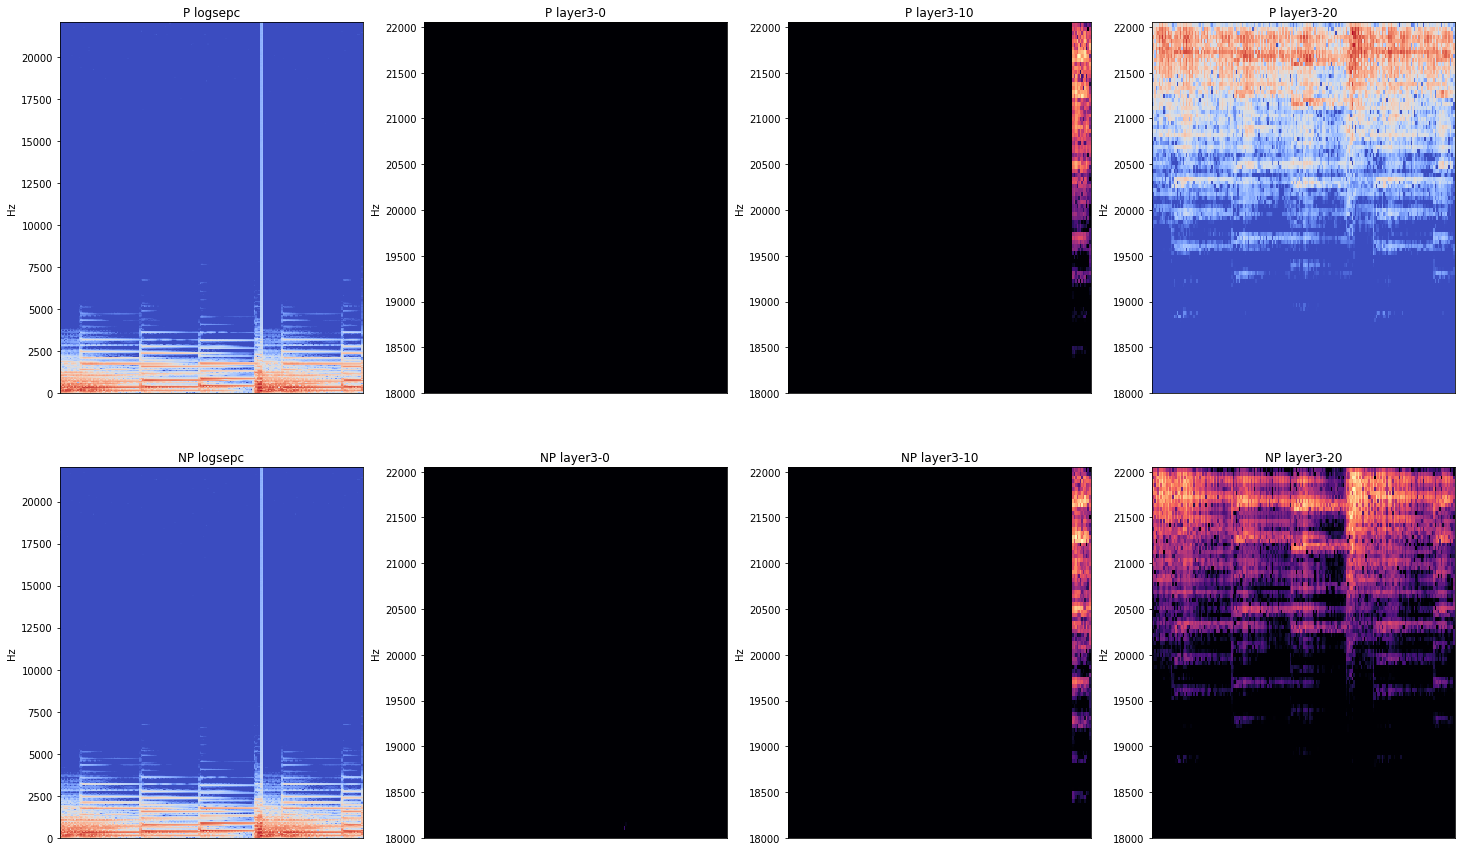

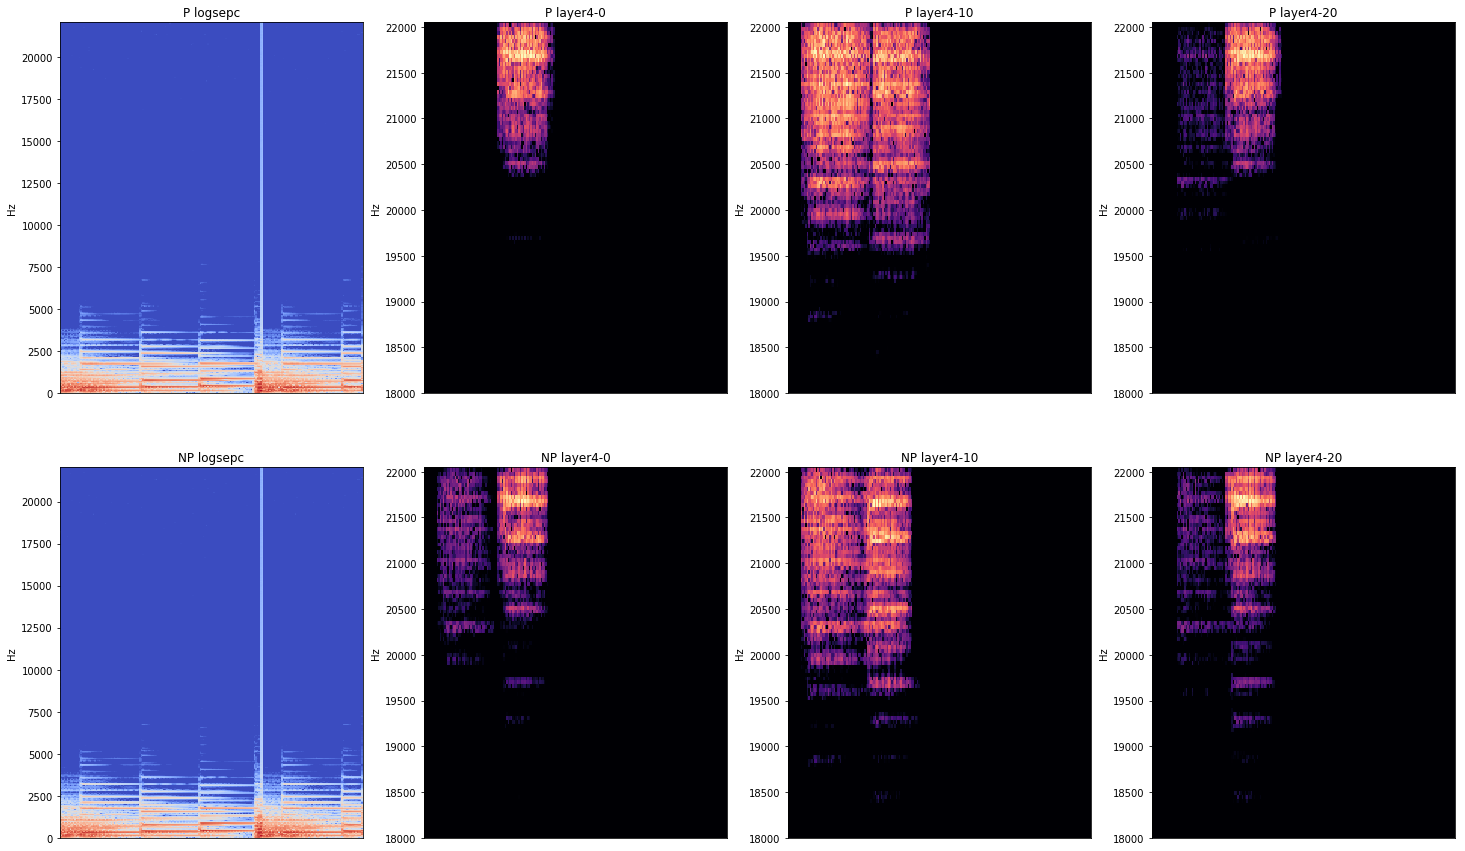

In [392]:
ftind = 2
keytext = "f{}t{}".format(n_freqs[ftind], n_times[ftind])
segspecftmask_dicp[keytext], segspecftmask_dicnp[keytext] = plotlayer_segment_spectrogram_ft(ftind, n_freqs, n_times, 
                                                                                             input_type, dataset_type, 
                                                                                             dir_pedal_npy, validation, 
                                                                                             instance)

Using cnn model with n_freq=3 and n_time=10.
Calculating the decoved mask for layer 1...
Calculating the decoved mask for layer 2...
Calculating the decoved mask for layer 3...
Calculating the decoved mask for layer 4...
Done!


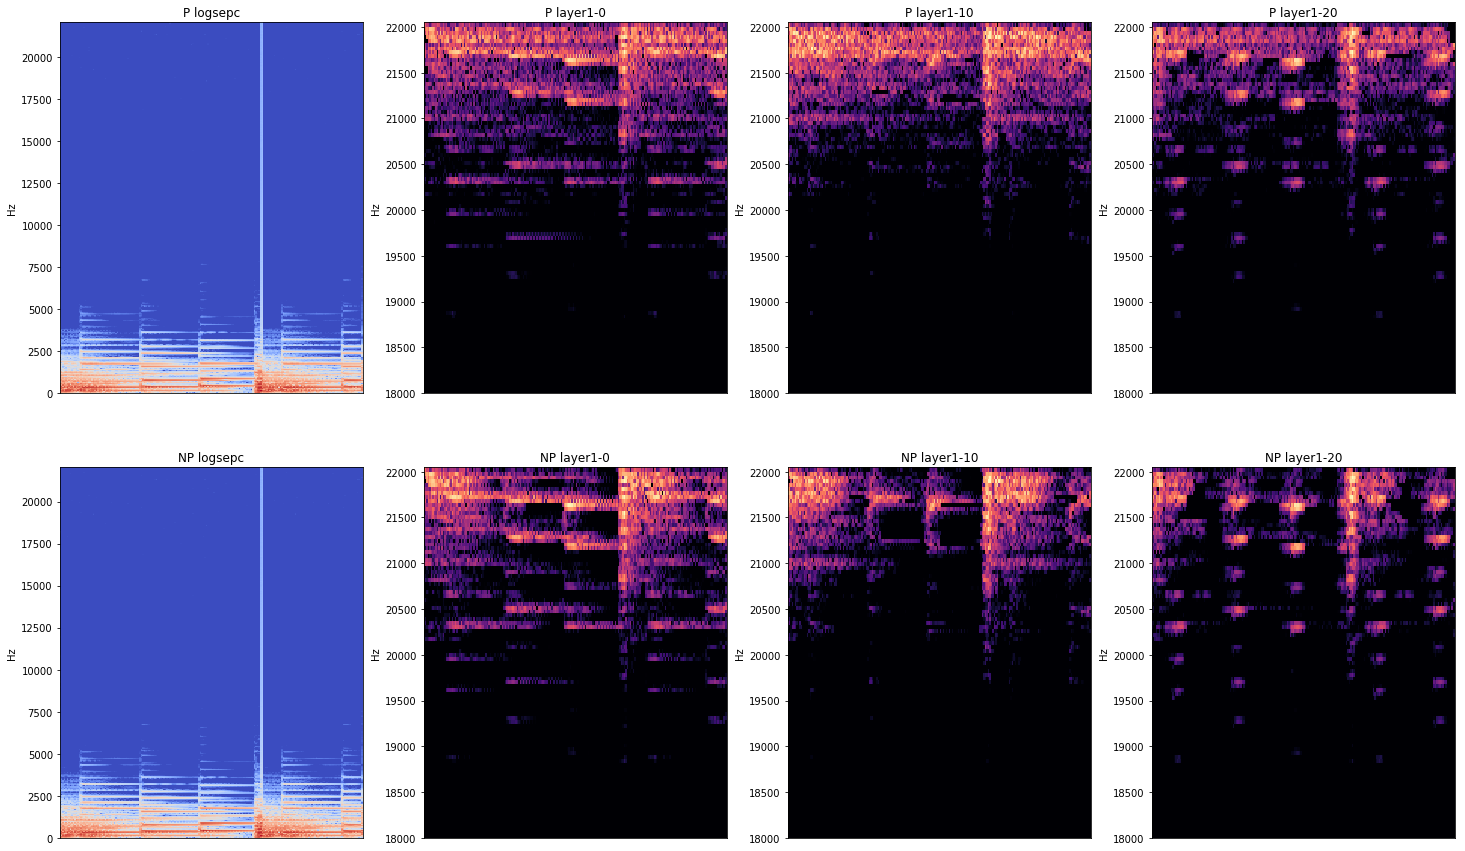

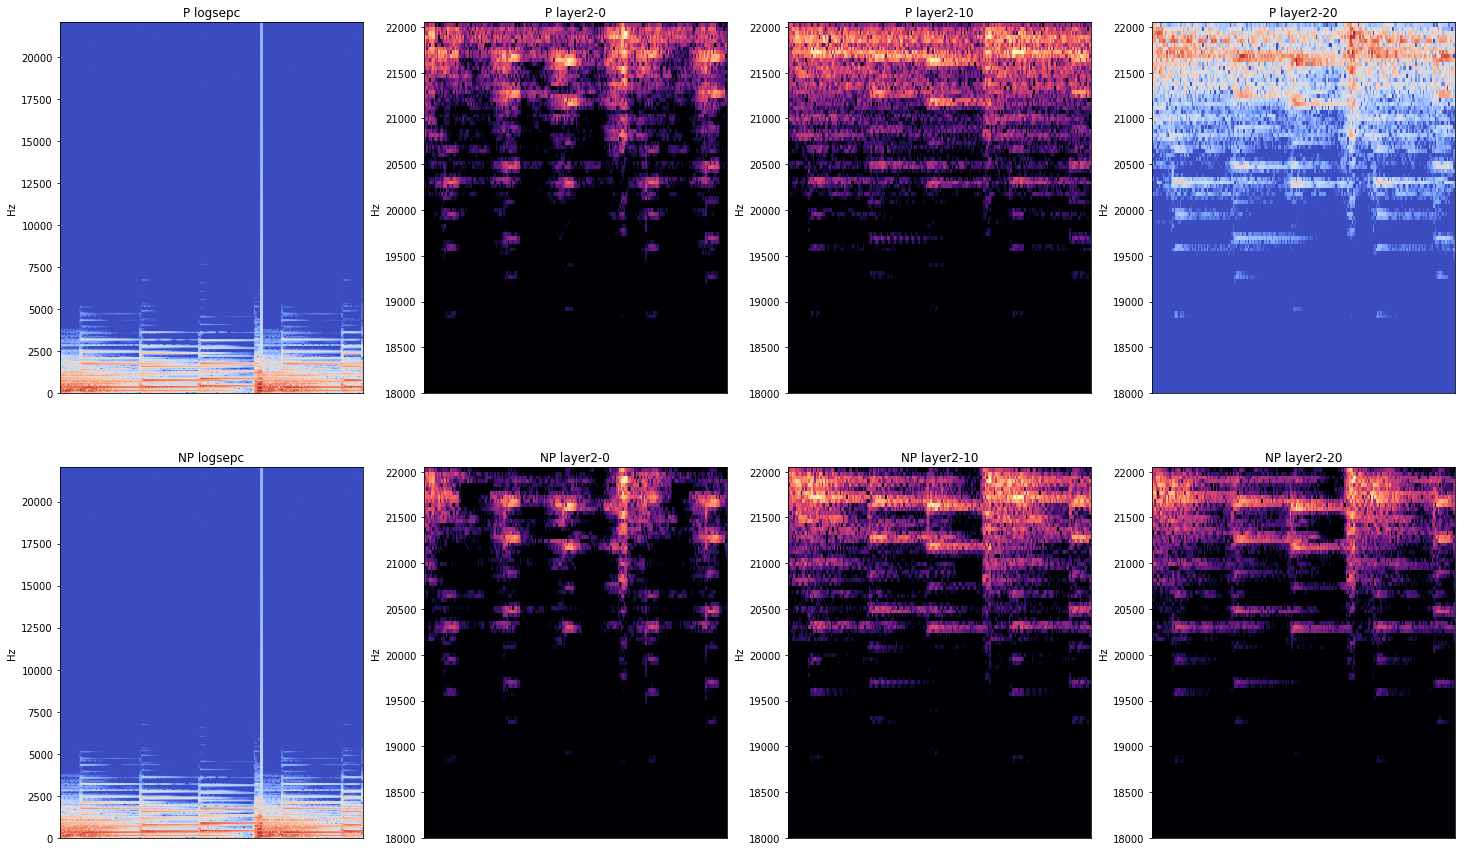

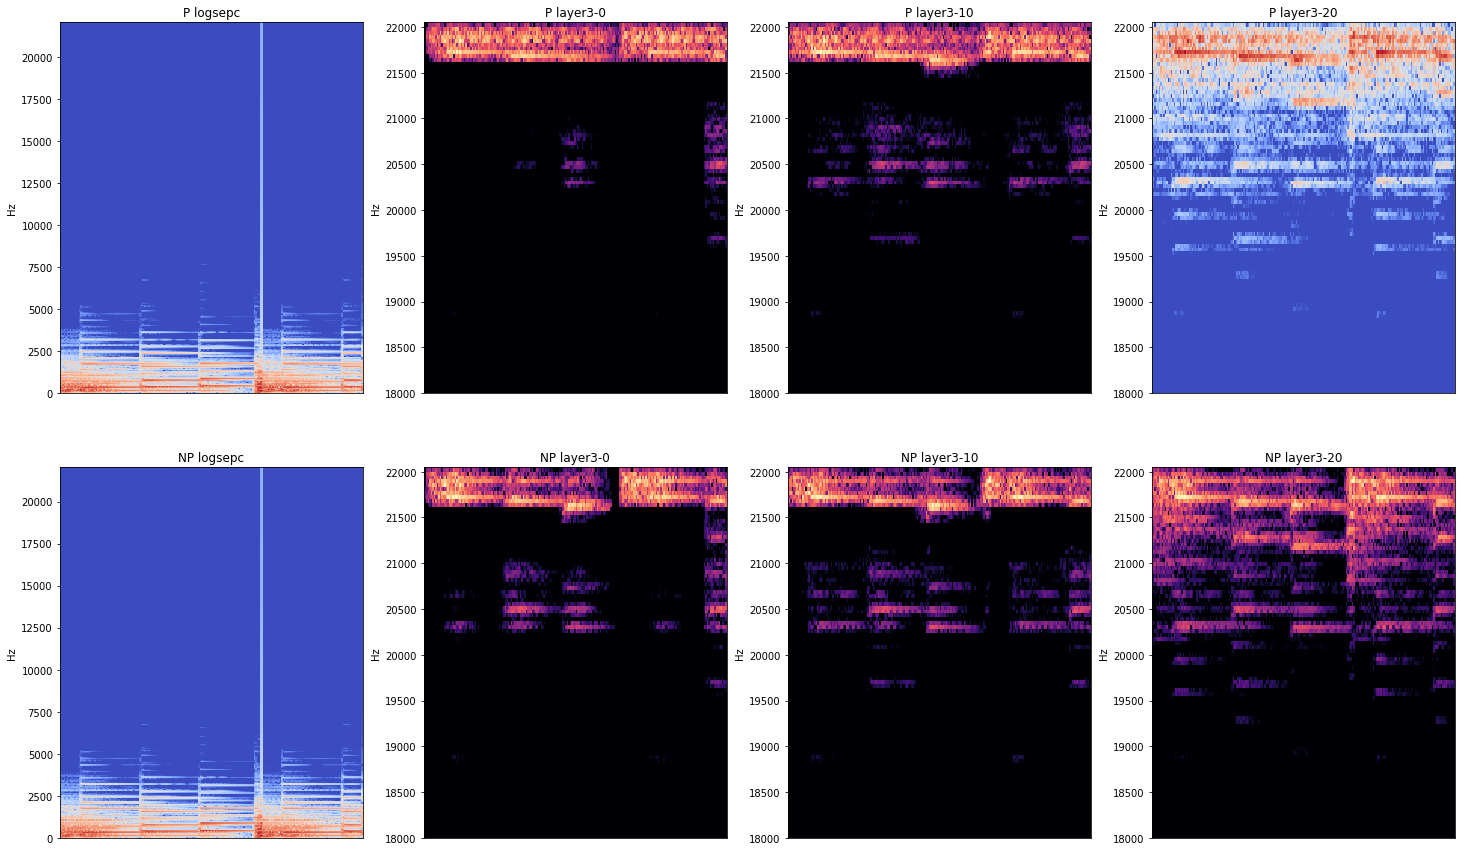

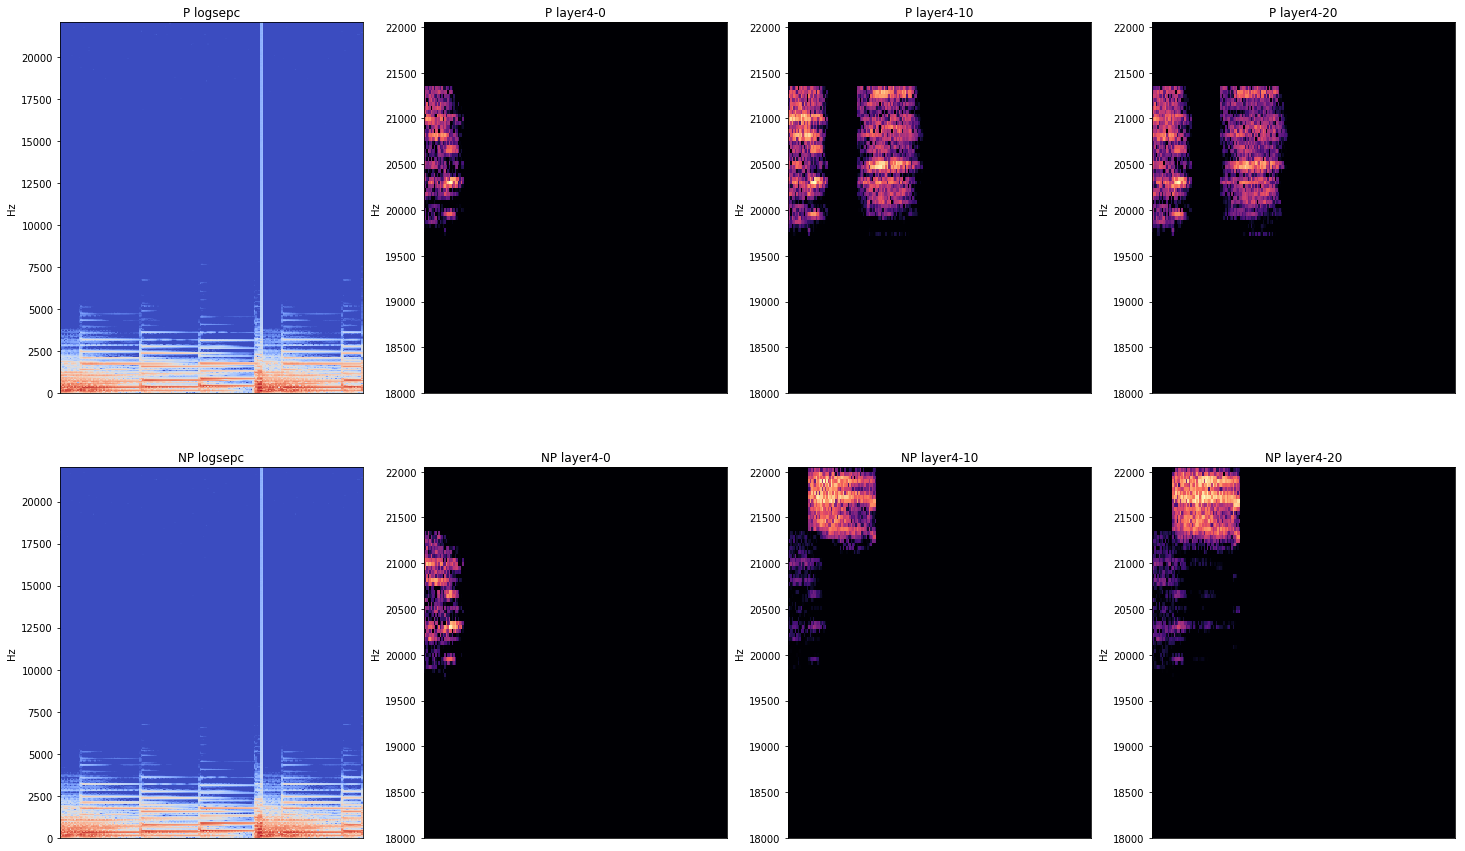

In [393]:
ftind = 3
keytext = "f{}t{}".format(n_freqs[ftind], n_times[ftind])
segspecftmask_dicp[keytext], segspecftmask_dicnp[keytext] = plotlayer_segment_spectrogram_ft(ftind, n_freqs, n_times, 
                                                                                             input_type, dataset_type, 
                                                                                             dir_pedal_npy, validation, 
                                                                                             instance)

Using cnn model with n_freq=3 and n_time=20.
Calculating the decoved mask for layer 1...
Calculating the decoved mask for layer 2...
Calculating the decoved mask for layer 3...
Calculating the decoved mask for layer 4...
Done!


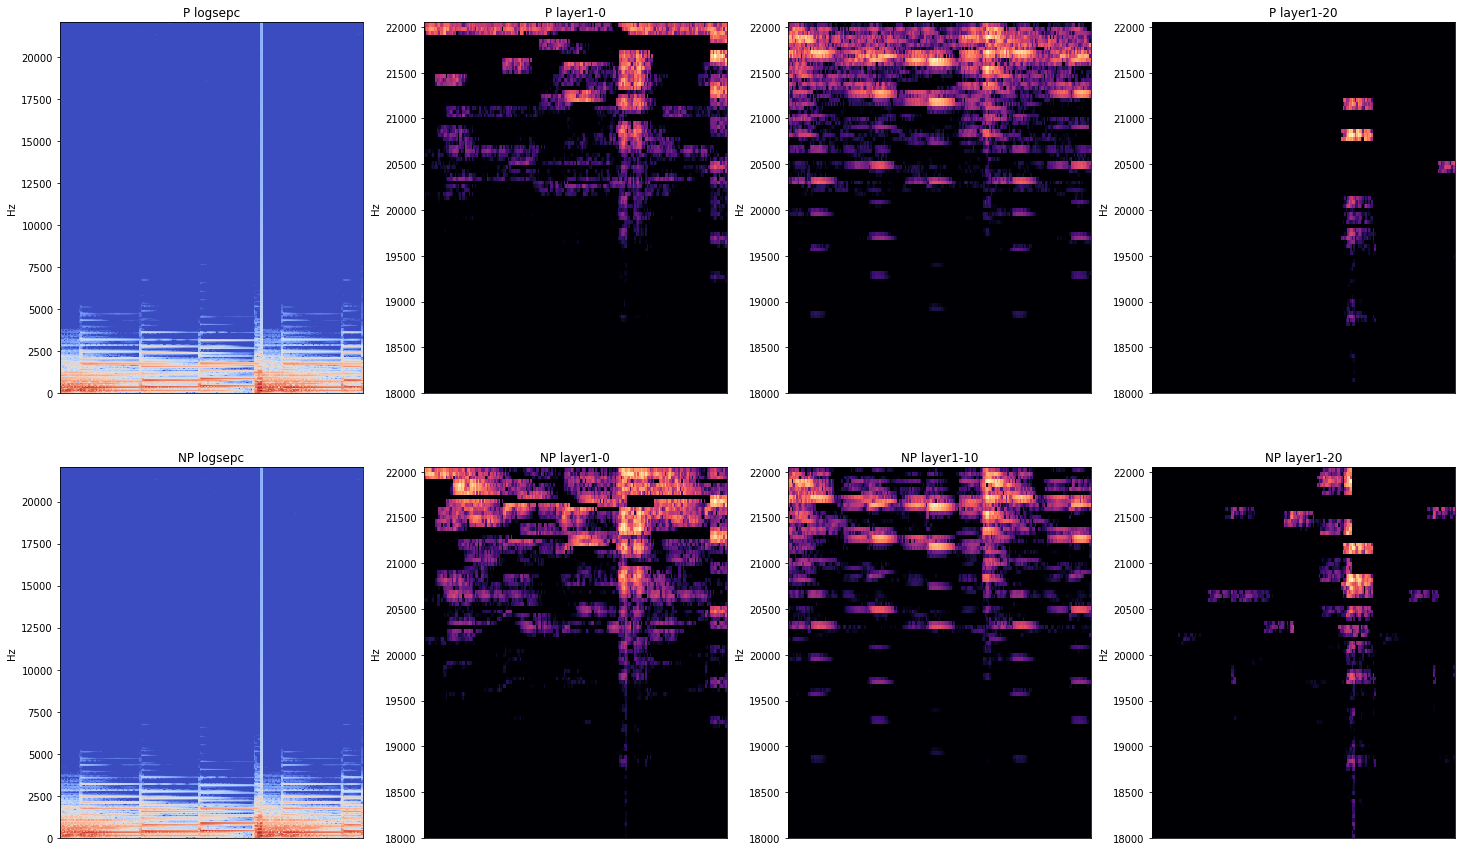

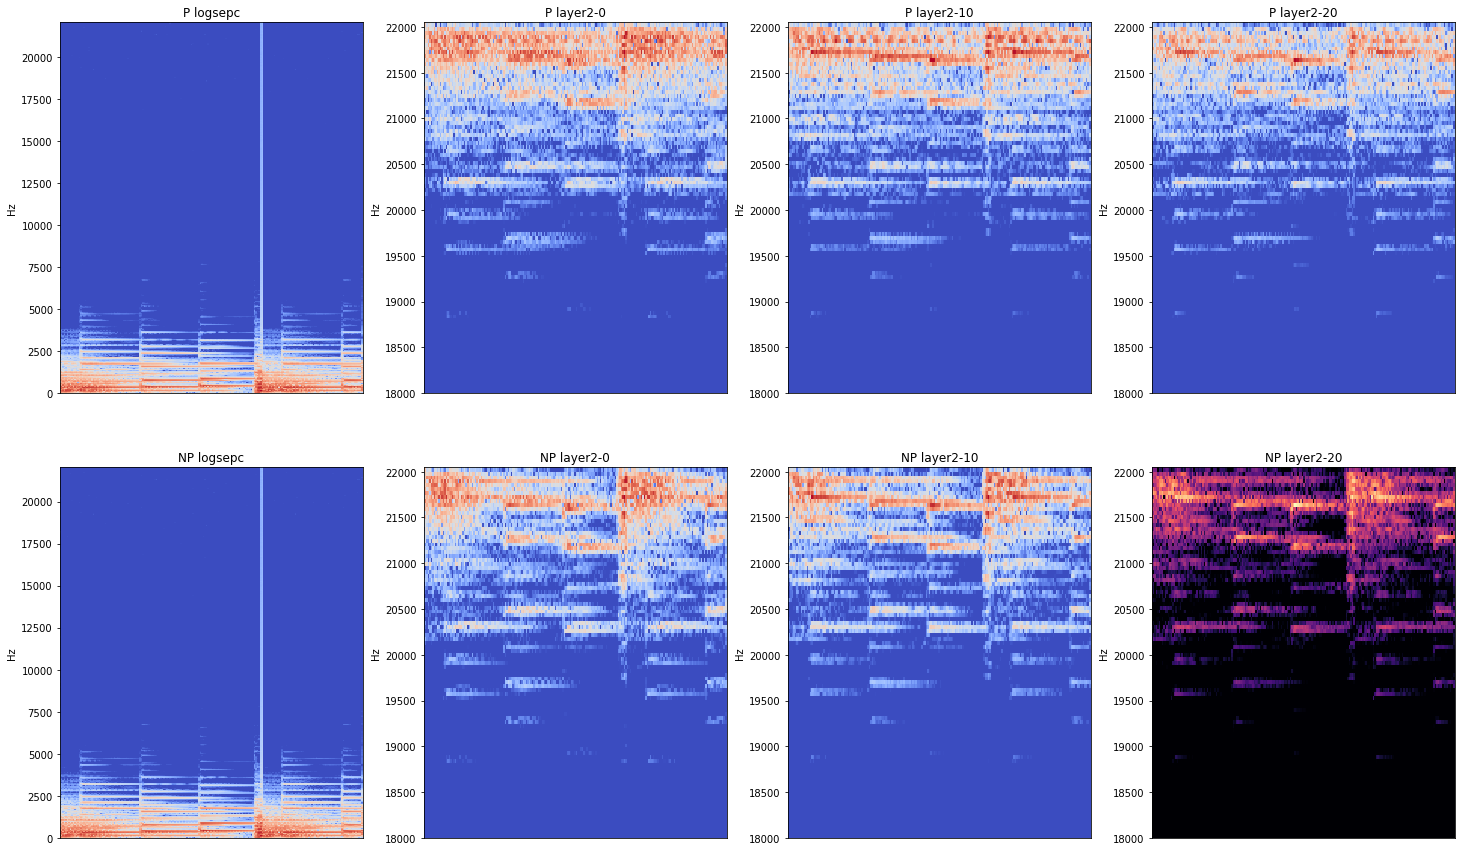

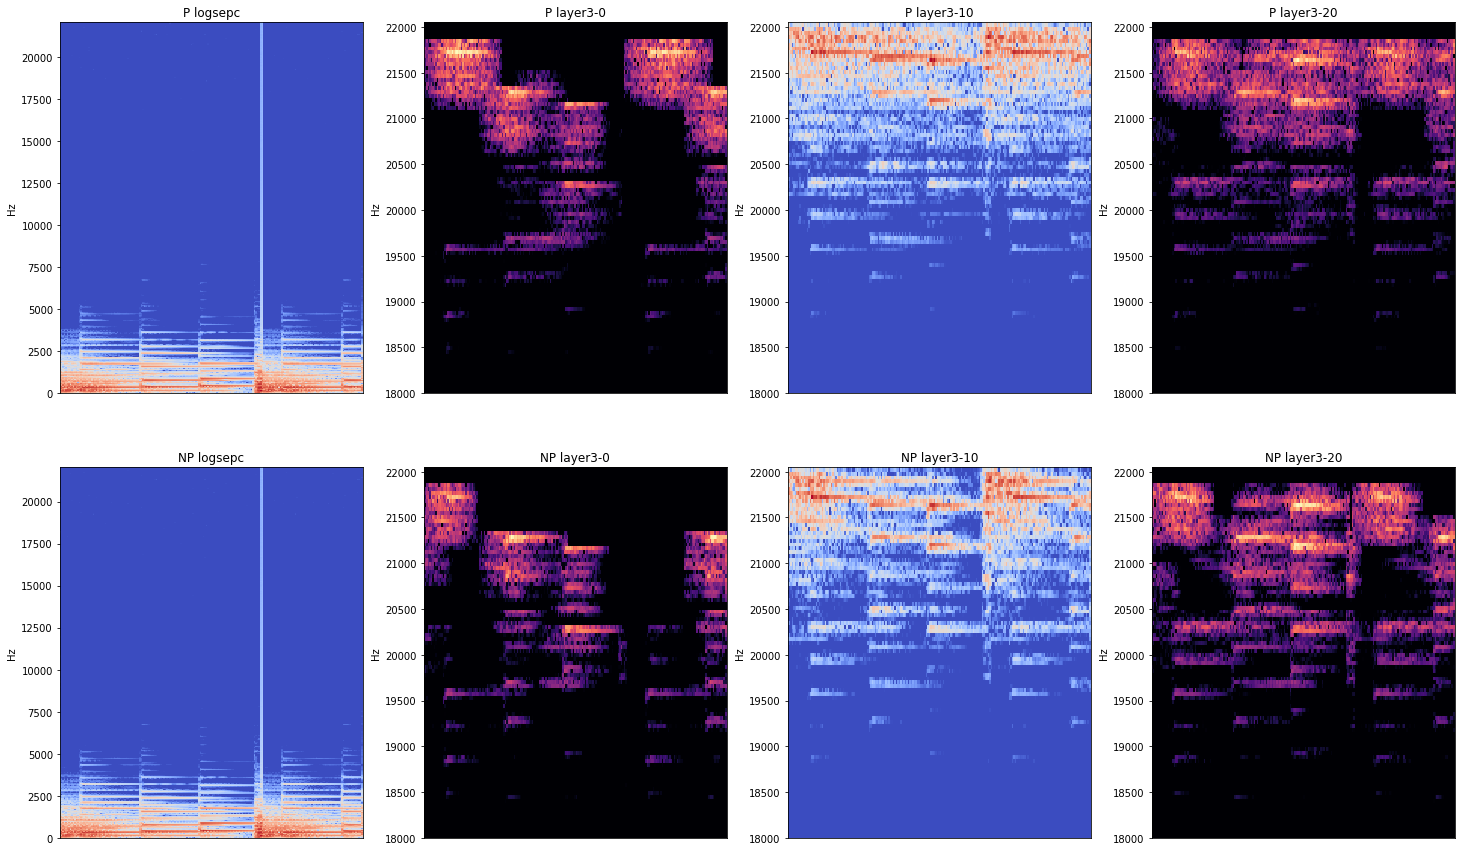

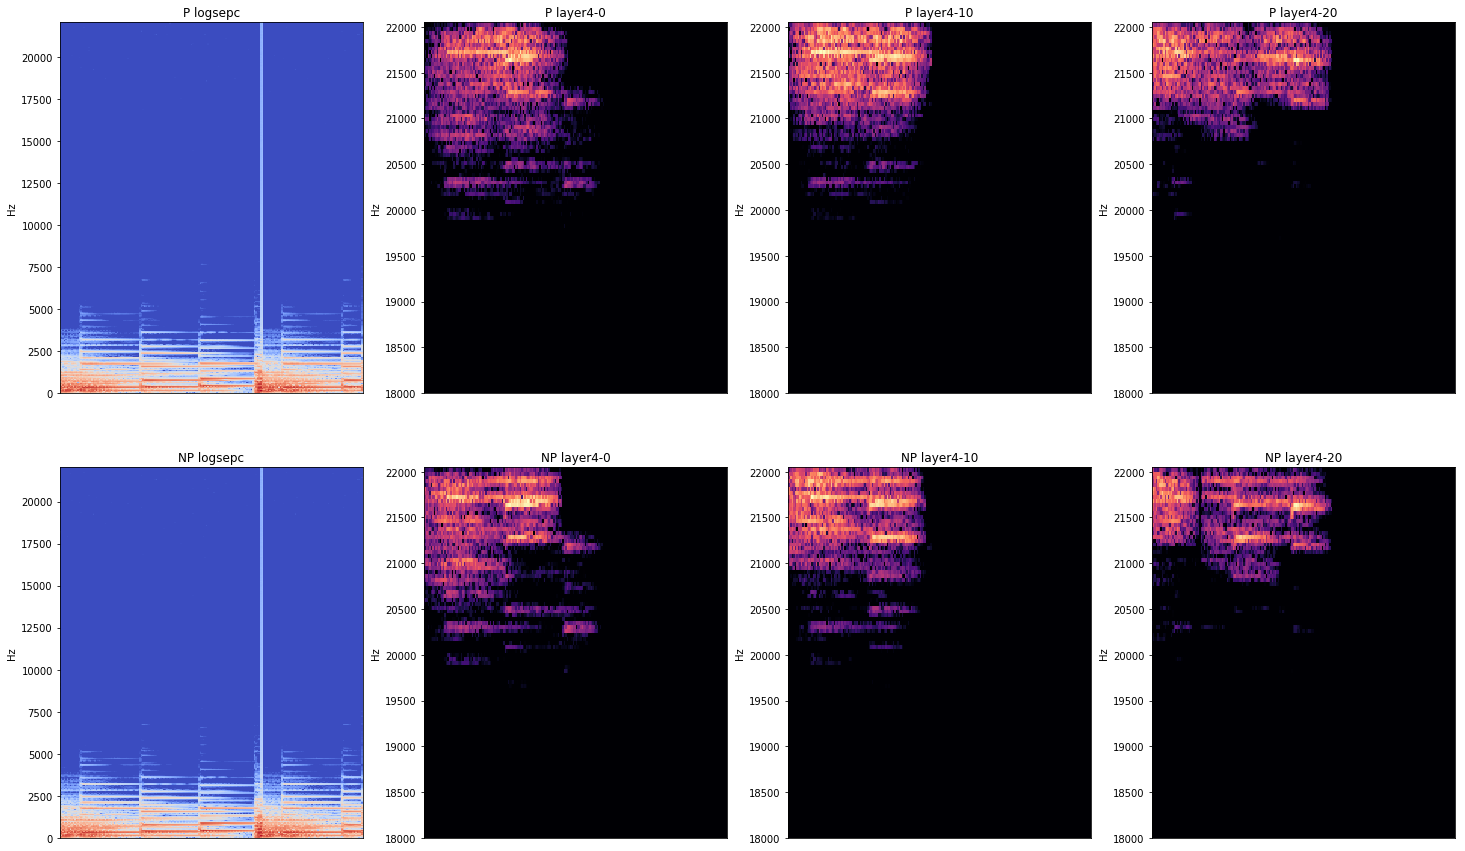

In [394]:
ftind = 4
keytext = "f{}t{}".format(n_freqs[ftind], n_times[ftind])
segspecftmask_dicp[keytext], segspecftmask_dicnp[keytext] = plotlayer_segment_spectrogram_ft(ftind, n_freqs, n_times, 
                                                                                             input_type, dataset_type, 
                                                                                             dir_pedal_npy, validation, 
                                                                                             instance)

Using cnn model with n_freq=3 and n_time=30.
Calculating the decoved mask for layer 1...
Calculating the decoved mask for layer 2...
Calculating the decoved mask for layer 3...
Calculating the decoved mask for layer 4...
Done!


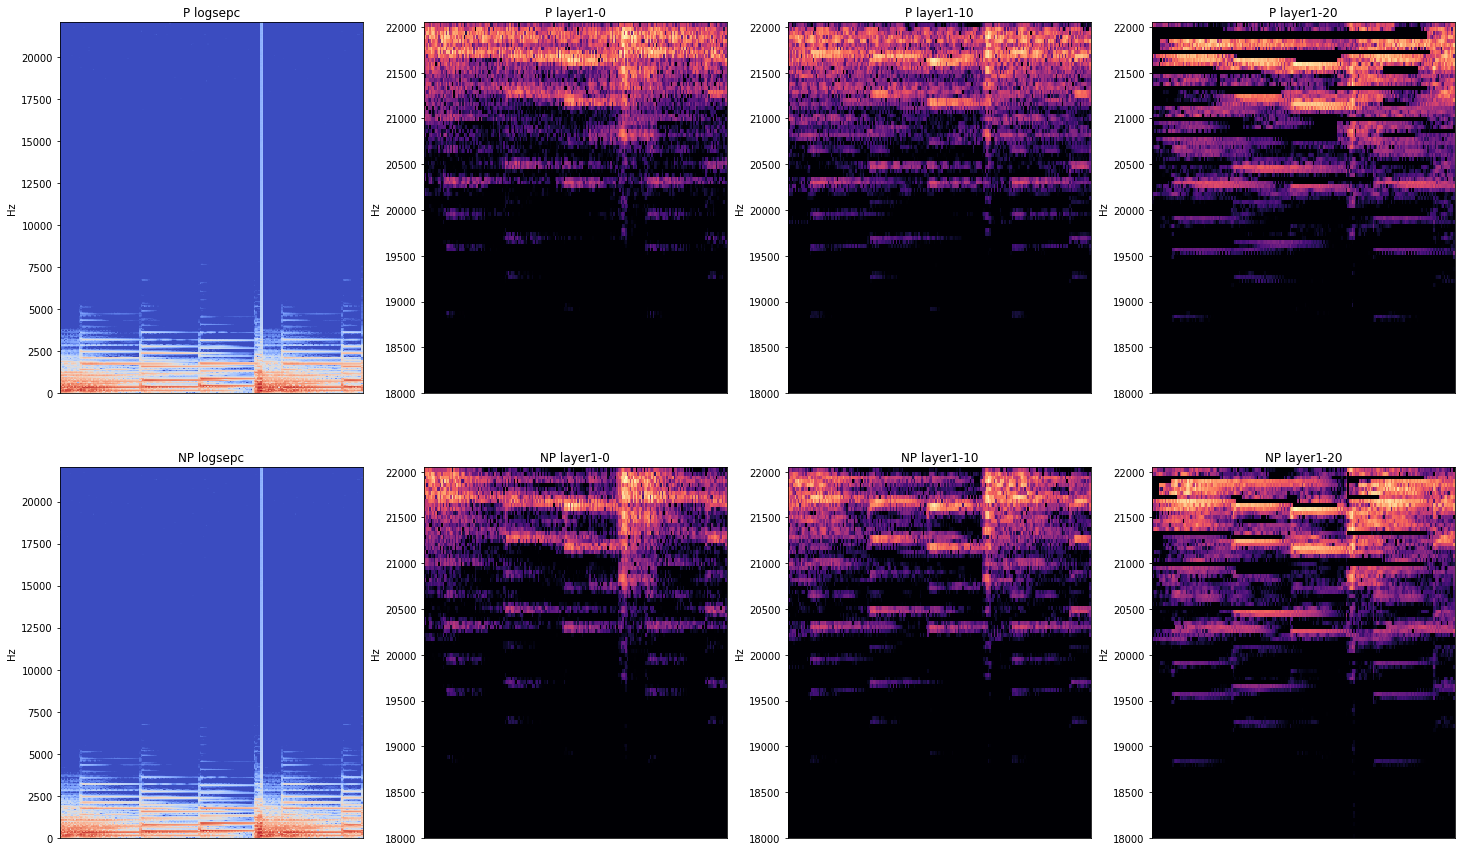

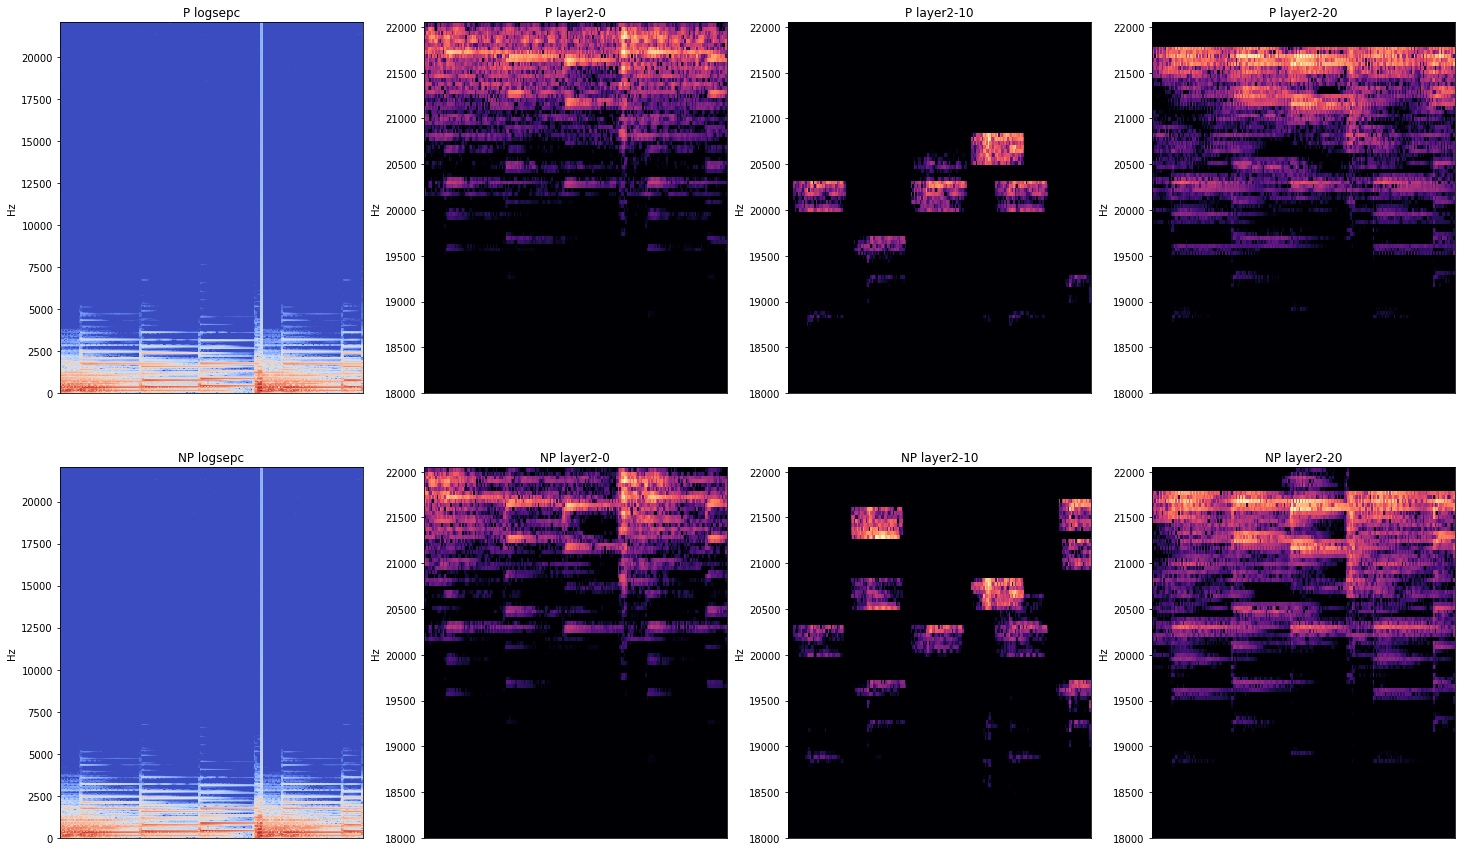

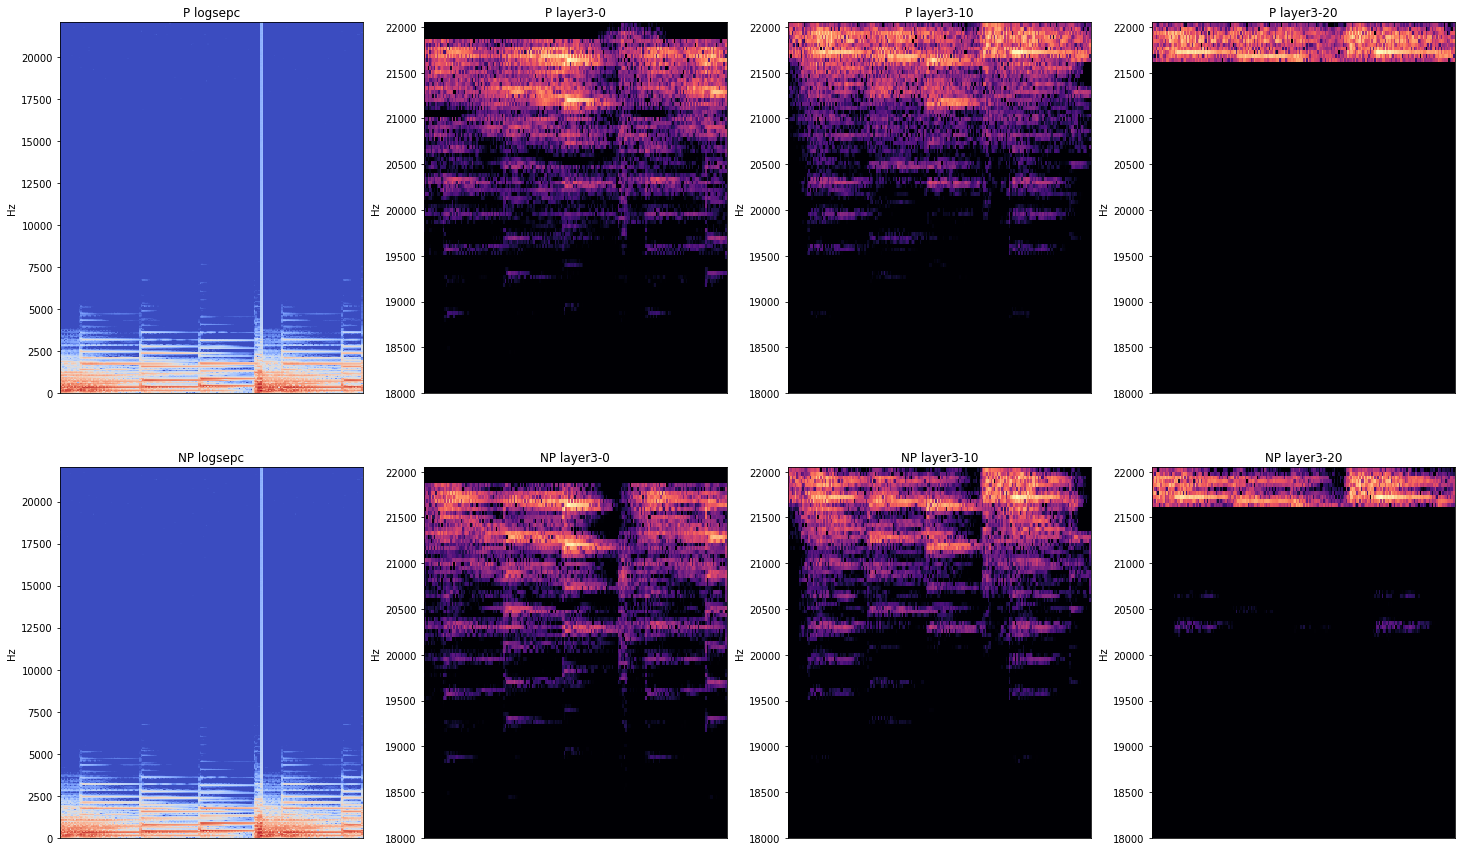

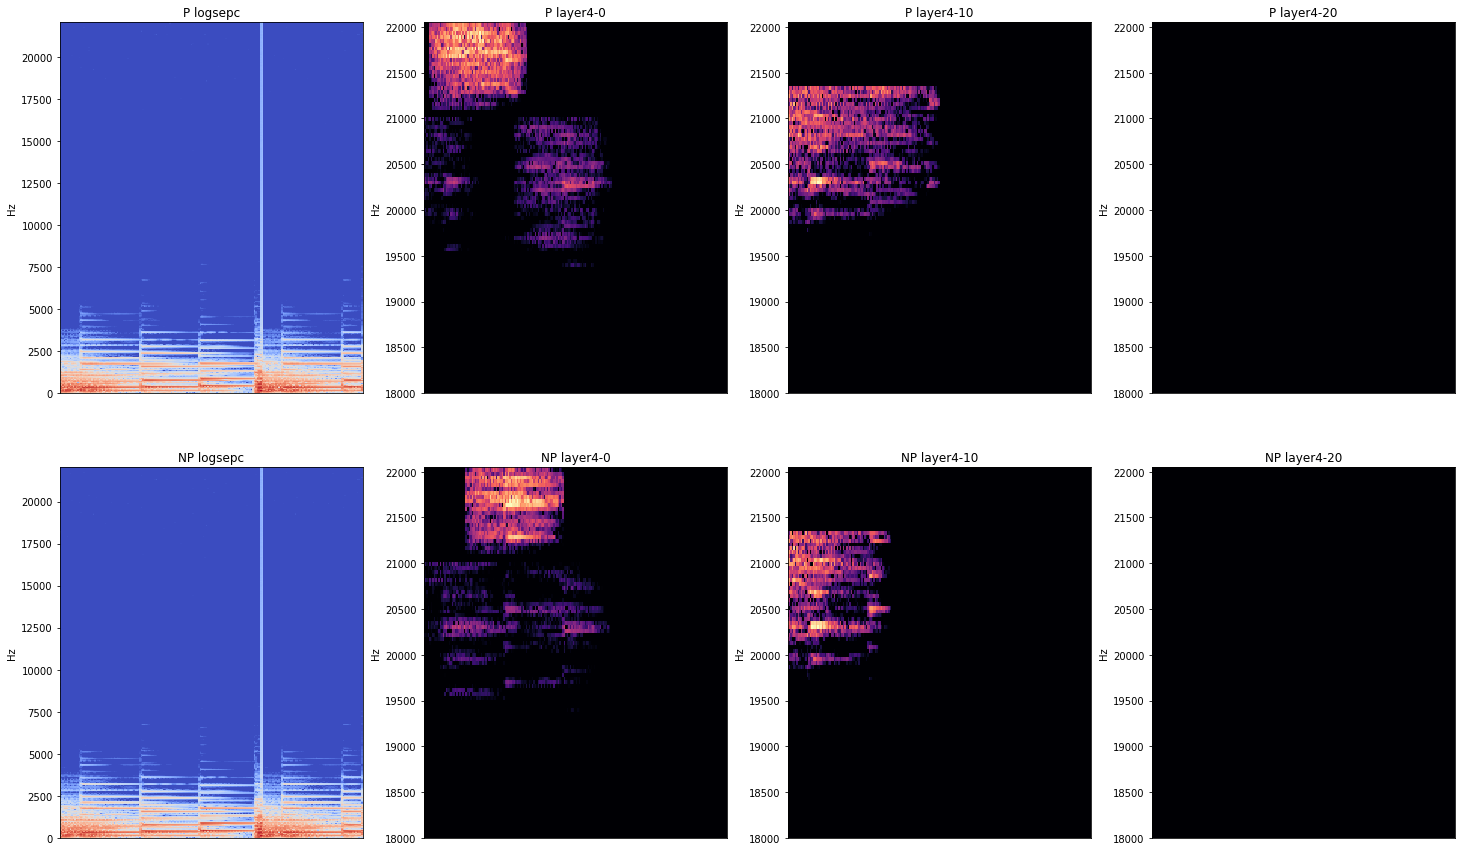

In [395]:
ftind = 5
keytext = "f{}t{}".format(n_freqs[ftind], n_times[ftind])
segspecftmask_dicp[keytext], segspecftmask_dicnp[keytext] = plotlayer_segment_spectrogram_ft(ftind, n_freqs, n_times, 
                                                                                             input_type, dataset_type, 
                                                                                             dir_pedal_npy, validation, 
                                                                                             instance)

In [397]:
22050-18000

4050

In [399]:
librosa.note_to_hz(['C8'])

array([ 4186.00904481])